# FRED-MD for Univariate Forecasting

Dataset contains 134 macroeconomic and financial variables at monthly frequency, starting in 1959 till present. The dataset is updated regularly. 

First, this notebook loads and processes the dataset. The processing includes transforming each series to be stationary according to the transformation codes and removing outliers, as laid out by McCracken and Ng (2015).

Following this I implement various univariate models, including machine learning features, to test their macroeconomic forecasting capabilities. These models are a replication of Coulombe et al. (2019) "How is Machine Learning Useful for Macroeconomic Forecasting?".

In [1]:
## Load library 
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

## For statistics and math
from statsmodels.tsa import stattools
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt

## For CV and ML methods
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR

## For time series
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics

## Load Data

In [2]:
data_t = pd.read_csv('data/current.csv')
series = list(data_t.columns.values[1:])
tcodes = pd.DataFrame(data_t.iloc[0,1:]).T
date = pd.DataFrame(data_t.iloc[1:742,0])
rawdata = data_t.drop([0,742], axis = 0).drop(['sasdate'], axis = 1).reset_index(drop=True)

In [3]:
rawdata.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
0,2437.296,2288.8,17.302,292258.8329,18235.77392,22.6250,23.4581,22.1904,32.4078,21.9882,...,11.358,2.13,2.45,2.04,NaN,274.9,6476.0,12298.0,84.2043,NaN
1,2446.902,2297.0,17.482,294429.5453,18369.56308,23.0681,23.7747,22.3827,32.6455,22.1036,...,11.375,2.14,2.46,2.05,NaN,276.0,6476.0,12298.0,83.5280,NaN
2,2462.689,2314.0,17.647,293425.3813,18523.05762,23.4004,23.9186,22.4925,32.6455,22.5365,...,11.395,2.15,2.45,2.07,NaN,277.4,6508.0,12349.0,81.6405,NaN
3,2478.744,2330.3,17.584,299331.6505,18534.46600,23.8989,24.2641,22.8221,33.1606,22.6807,...,11.436,2.16,2.47,2.08,NaN,278.1,6620.0,12484.0,81.8099,NaN
4,2493.228,2345.8,17.796,301372.9597,18679.66354,24.2589,24.4655,23.0418,33.3190,23.1424,...,11.454,2.17,2.48,2.08,95.3,280.1,6753.0,12646.0,80.7315,NaN


In [4]:
tcodes

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
0,5,5,5,5,5,5,5,5,5,5,...,6,6,6,6,2,6,6,6,6,1


In [5]:
series

['RPI',
 'W875RX1',
 'DPCERA3M086SBEA',
 'CMRMTSPLx',
 'RETAILx',
 'INDPRO',
 'IPFPNSS',
 'IPFINAL',
 'IPCONGD',
 'IPDCONGD',
 'IPNCONGD',
 'IPBUSEQ',
 'IPMAT',
 'IPDMAT',
 'IPNMAT',
 'IPMANSICS',
 'IPB51222S',
 'IPFUELS',
 'CUMFNS',
 'HWI',
 'HWIURATIO',
 'CLF16OV',
 'CE16OV',
 'UNRATE',
 'UEMPMEAN',
 'UEMPLT5',
 'UEMP5TO14',
 'UEMP15OV',
 'UEMP15T26',
 'UEMP27OV',
 'CLAIMSx',
 'PAYEMS',
 'USGOOD',
 'CES1021000001',
 'USCONS',
 'MANEMP',
 'DMANEMP',
 'NDMANEMP',
 'SRVPRD',
 'USTPU',
 'USWTRADE',
 'USTRADE',
 'USFIRE',
 'USGOVT',
 'CES0600000007',
 'AWOTMAN',
 'AWHMAN',
 'HOUST',
 'HOUSTNE',
 'HOUSTMW',
 'HOUSTS',
 'HOUSTW',
 'PERMIT',
 'PERMITNE',
 'PERMITMW',
 'PERMITS',
 'PERMITW',
 'ACOGNO',
 'AMDMNOx',
 'ANDENOx',
 'AMDMUOx',
 'BUSINVx',
 'ISRATIOx',
 'M1SL',
 'M2SL',
 'M2REAL',
 'BOGMBASE',
 'TOTRESNS',
 'NONBORRES',
 'BUSLOANS',
 'REALLN',
 'NONREVSL',
 'CONSPI',
 'S&P 500',
 'S&P: indust',
 'S&P div yield',
 'S&P PE ratio',
 'FEDFUNDS',
 'CP3Mx',
 'TB3MS',
 'TB6MS',
 'GS1',
 'G

In [6]:
date['sasdate'] = pd.to_datetime(date['sasdate'], format='%m/%d/%Y')
date

,sasdate
1,1959-01-01
2,1959-02-01
3,1959-03-01
4,1959-04-01
5,1959-05-01
...,...
737,2020-05-01
738,2020-06-01
739,2020-07-01
740,2020-08-01


In [7]:
T = rawdata.shape[0] # time periods
N = rawdata.shape[1] # indicators

In [8]:
print('Dataset has', T, 'time periods and', N, 'indicators.')

Dataset has 741 time periods and 128 indicators.


## Proprocessing

This includes 2 steps
* transform data to make it stationary.
* remove outliers and missing values.

### Transform data
1. No transformation: $x_t$
2. First difference: $\Delta x_t=x_t-x_{t-1}$
3. Second difference: $\Delta^2 x_t= \Delta(x_t-x_{t-1})=x_t-2x_{t-1}+x_{t-2}$
4. Natural log: $\ln(x_t)$
5. First difference of natural log: $\Delta\ln(x_t)=\ln(x_t)-\ln(x_{t-1})$
6. Second difference of natural log: $\Delta^2\ln(x_t)=\ln(x_t)-2\ln(x_{t-1})+\ln(x_{t-2})$
7. First difference of percentage change: $\Delta(\frac{x_t}{x_{t-1}}-1)$

In [9]:
# Subfunction for transformation: input is a 1d array of each series, output is the transformed version of that series, 
# transformation code tcode also passed as input

def transxf(x,tcode):
    n = x.shape[0]
    small = 1e-6
    y = np.zeros(n)
    y1 = np.zeros(n)
    
    if tcode == 1:
        y=x
    elif tcode == 2:
        y[1:n] = x[1:n]-x[0:n-1]
    elif tcode == 3:
        y[2:n] = x[2:n] - 2*x[1:n-1] + x[0:n-2]
    elif tcode == 4:
        if np.amin(x) > small:
            y = np.log(x)
    elif tcode == 5:
        if np.amin(x) > small:
            x = np.log(x)
            y[1:n] = x[1:n]-x[0:n-1]
    elif tcode == 6:
        if np.amin(x) > small:
            x = np.log(x)
            y[2:n] = x[2:n] - 2*x[1:n-1] + x[0:n-2]
    elif tcode == 7:
        y1[1:n] = (x[1:n]-x[0:n-1])/x[0:n-1]
        y[2:n] = y1[2:n] - y1[1:n-1]
    else:
        print('Error!!')
        
    return y

In [10]:
# Function to transform data: takes as input the raw data, transformation codes and series names, 
# Calls the subfunction to transform each series according to the transformation codes

def transform(rawdata, tcodes, series):
    yt = np.zeros(T)
    
    for (key,data) in rawdata.iteritems():
        print('Ind Name: ', key, ' ')
        tcode = int(tcodes[key].values)
        x = np.array(data.values)
    
        temp = transxf(x,tcode)
        yt = np.column_stack((yt, temp))
        
    transdata = pd.DataFrame(yt).drop([0], axis = 1)
    transdata.columns = series
    
    return transdata

In [11]:
transdata = transform(rawdata,tcodes,series)

Ind Name:  RPI  
Ind Name:  W875RX1  
Ind Name:  DPCERA3M086SBEA  
Ind Name:  CMRMTSPLx  
Ind Name:  RETAILx  
Ind Name:  INDPRO  
Ind Name:  IPFPNSS  
Ind Name:  IPFINAL  
Ind Name:  IPCONGD  
Ind Name:  IPDCONGD  
Ind Name:  IPNCONGD  
Ind Name:  IPBUSEQ  
Ind Name:  IPMAT  
Ind Name:  IPDMAT  
Ind Name:  IPNMAT  
Ind Name:  IPMANSICS  
Ind Name:  IPB51222S  
Ind Name:  IPFUELS  
Ind Name:  CUMFNS  
Ind Name:  HWI  
Ind Name:  HWIURATIO  
Ind Name:  CLF16OV  
Ind Name:  CE16OV  
Ind Name:  UNRATE  
Ind Name:  UEMPMEAN  
Ind Name:  UEMPLT5  
Ind Name:  UEMP5TO14  
Ind Name:  UEMP15OV  
Ind Name:  UEMP15T26  
Ind Name:  UEMP27OV  
Ind Name:  CLAIMSx  
Ind Name:  PAYEMS  
Ind Name:  USGOOD  
Ind Name:  CES1021000001  
Ind Name:  USCONS  
Ind Name:  MANEMP  
Ind Name:  DMANEMP  
Ind Name:  NDMANEMP  
Ind Name:  SRVPRD  
Ind Name:  USTPU  
Ind Name:  USWTRADE  
Ind Name:  USTRADE  
Ind Name:  USFIRE  
Ind Name:  USGOVT  
Ind Name:  CES0600000007  
Ind Name:  AWOTMAN  
Ind Name:  AWHMAN  


In [12]:
transdata.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,NaN
1,0.003934,0.003576,0.010350,0.0,0.007310,0.019395,0.013406,0.008629,0.007308,0.005235,...,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.0,0.0,0.000000,NaN
2,0.006431,0.007374,0.009394,0.0,0.008321,0.014302,0.006034,0.004894,0.000000,0.019396,...,0.000261,-0.000022,-0.008147,0.004819,NaN,0.001066,0.0,0.0,-0.014792,NaN
3,0.006498,0.007019,-0.003576,0.0,0.000616,0.021079,0.014341,0.014547,0.015655,0.006378,...,0.001835,-0.000022,0.012203,-0.004890,NaN,-0.002539,0.0,0.0,0.024929,NaN
4,0.005826,0.006629,0.011984,0.0,0.007803,0.014951,0.008266,0.009581,0.004765,0.020152,...,-0.002019,-0.000021,-0.004090,-0.004819,NaN,0.004646,0.0,0.0,-0.015342,NaN


Remove the first 2 rows of data since several indicators are of order I(2) and were transformed through second differencing. 

In [13]:
transdata = transdata[2:].reset_index(drop=True)

transdata.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
0,0.006431,0.007374,0.009394,0.0,0.008321,0.014302,0.006034,0.004894,0.000000,0.019396,...,0.000261,-0.000022,-0.008147,0.004819,NaN,0.001066,0.0,0.0,-0.014792,NaN
1,0.006498,0.007019,-0.003576,0.0,0.000616,0.021079,0.014341,0.014547,0.015655,0.006378,...,0.001835,-0.000022,0.012203,-0.004890,NaN,-0.002539,0.0,0.0,0.024929,NaN
2,0.005826,0.006629,0.011984,0.0,0.007803,0.014951,0.008266,0.009581,0.004765,0.020152,...,-0.002019,-0.000021,-0.004090,-0.004819,NaN,0.004646,0.0,0.0,-0.015342,NaN
3,0.003108,0.003022,0.003646,0.0,0.009064,0.001141,0.007034,0.007127,-0.004765,0.007456,...,0.002087,-0.004619,0.003992,0.004796,NaN,-0.000760,0.0,0.0,-0.012252,NaN
4,-0.000586,-0.000808,-0.003365,0.0,-0.000330,-0.024239,0.001168,0.008248,0.013056,0.019609,...,-0.000100,0.000000,-0.004040,-0.004796,NaN,-0.002158,0.0,0.0,0.029341,NaN


### Remove Outliers

Data point $x$ of a particular series is denoted as an outlier if $|x-\text{median}| > 10\times\text{interquartile range}$, where $\text{median}$ and $\text{interquartile range}$ are calculated for each series in the data.

In [14]:
transdata.describe()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
count,739.000000,739.000000,739.000000,739.0,739.000000,739.000000,739.000000,739.000000,739.000000,739.000000,...,739.000000,739.000000,739.000000,739.000000,512.000000,739.000000,739.0,739.0,739.000000,699.000000
mean,0.002680,0.002447,0.002591,0.0,0.004598,0.002005,0.001916,0.001990,0.001548,0.002269,...,0.000002,-0.000009,-0.000021,0.000001,-0.006445,0.000005,0.0,0.0,0.000027,19.186385
std,0.007354,0.006232,0.008363,0.0,0.015158,0.009914,0.010034,0.010938,0.010907,0.034228,...,0.001592,0.003993,0.009120,0.004779,3.985077,0.006172,0.0,0.0,0.010873,7.408469
min,-0.050480,-0.062003,-0.130778,0.0,-0.159099,-0.135622,-0.153028,-0.161809,-0.131066,-0.516216,...,-0.009388,-0.029509,-0.068074,-0.026868,-17.300000,-0.042202,0.0,0.0,-0.080827,8.016400
25%,0.000744,0.000349,-0.000033,0.0,-0.000956,-0.001732,-0.002356,-0.002578,-0.003468,-0.007722,...,-0.000831,-0.002169,-0.003461,-0.002324,-2.300000,-0.002078,0.0,0.0,-0.005880,14.093800
50%,0.002850,0.002863,0.002677,0.0,0.004813,0.002321,0.002543,0.002292,0.001528,0.002685,...,-0.000066,-0.000015,-0.000025,-0.000010,-0.100000,-0.000023,0.0,0.0,0.000451,17.557000
75%,0.004838,0.004925,0.005684,0.0,0.010841,0.006480,0.006619,0.007064,0.006717,0.013213,...,0.000770,0.001984,0.003622,0.002142,2.425000,0.002202,0.0,0.0,0.006112,22.476950
max,0.120862,0.040115,0.081790,0.0,0.167881,0.059981,0.069548,0.083456,0.081958,0.349486,...,0.016017,0.019303,0.053050,0.024828,17.300000,0.059594,0.0,0.0,0.049668,67.151000


In [15]:
## Function to remove outliers

def remove_outliers(X, series):
    """ This function takes a set of series and replaces outliers with NaN values
    Input:
            X: transformed dataset, each column is a series
    Output:
            Y: dataset where outliers replaces with NaN values
            n: number of outliers in the data
    Each data point x in the dataset X is defined as on outlier if 
    |x-median| > 10*interquartile range
    """
    
    # calculate median of each series
    median_X = np.array(transdata.median(axis = 0, skipna = True))
    
    # repeat median of each series for all data points of that series
    # median for each series is repeated along the rows
    median_X_mat = np.tile(median_X, [transdata.shape[0],1])
    
    # calculate interquartile range for each series
    IQR = np.array(transdata.quantile(q=0.75, axis=0)) - np.array(transdata.quantile(q=0.25, axis=0))
    
    # repeat interquartile range for all data points of that series
    IQR_mat = np.tile(IQR, [transdata.shape[0],1])
    
    # determine outliers 
    outlier = np.column_stack(np.where(np.absolute(np.array(transdata)- median_X_mat) > 10*IQR_mat))
    n = outlier.shape[0]
    
    # replace outliers with NaN values
    Y = np.array(transdata)
    Y[np.absolute(np.array(transdata)- median_X_mat) > 10*IQR_mat] = np.nan
    Y = pd.DataFrame(Y)
    Y.columns = series
    
    return Y, n

In [16]:
data, n = remove_outliers(transdata, series)

C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater


In [17]:
data.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
0,0.006431,0.007374,0.009394,0.0,0.008321,0.014302,0.006034,0.004894,0.000000,0.019396,...,0.000261,-0.000022,-0.008147,0.004819,NaN,0.001066,0.0,0.0,-0.014792,NaN
1,0.006498,0.007019,-0.003576,0.0,0.000616,0.021079,0.014341,0.014547,0.015655,0.006378,...,0.001835,-0.000022,0.012203,-0.004890,NaN,-0.002539,0.0,0.0,0.024929,NaN
2,0.005826,0.006629,0.011984,0.0,0.007803,0.014951,0.008266,0.009581,0.004765,0.020152,...,-0.002019,-0.000021,-0.004090,-0.004819,NaN,0.004646,0.0,0.0,-0.015342,NaN
3,0.003108,0.003022,0.003646,0.0,0.009064,0.001141,0.007034,0.007127,-0.004765,0.007456,...,0.002087,-0.004619,0.003992,0.004796,NaN,-0.000760,0.0,0.0,-0.012252,NaN
4,-0.000586,-0.000808,-0.003365,0.0,-0.000330,-0.024239,0.001168,0.008248,0.013056,0.019609,...,-0.000100,0.000000,-0.004040,-0.004796,NaN,-0.002158,0.0,0.0,0.029341,NaN


In [18]:
print(n, 'outliers removed from data.')

132 outliers removed from data.


In [19]:
print('Modified dataset has', data.shape[0], 'time periods and', data.shape[1], 'indicators.')

Modified dataset has 739 time periods and 128 indicators.


### Data Split

The historical dataset ranges from 1960:M1 to 2017:M12. To match the pseudo out-of-sample design in the paper, the historical data must be split into an insample period and an out-of-sample period, based on which forecast performance will be evaluated for each model. 

Insample period: 1960M1:1979M12, 240 months. 

Out-of-sample period: 1980M1:2017M12, 456 months.

Evaluation period: 456 months of the out-of-sample period. 

Forecast horizons: 1, 3, 9, 12 and 24 months.
 

In [20]:
# combine dates with transformed dataset
macrodata = pd.merge(data, date[2:].reset_index(drop=True), left_index=True, right_index=True)

In [21]:
macrodata.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx,sasdate
0,0.006431,0.007374,0.009394,0.0,0.008321,0.014302,0.006034,0.004894,0.000000,0.019396,...,-0.000022,-0.008147,0.004819,NaN,0.001066,0.0,0.0,-0.014792,NaN,1959-03-01
1,0.006498,0.007019,-0.003576,0.0,0.000616,0.021079,0.014341,0.014547,0.015655,0.006378,...,-0.000022,0.012203,-0.004890,NaN,-0.002539,0.0,0.0,0.024929,NaN,1959-04-01
2,0.005826,0.006629,0.011984,0.0,0.007803,0.014951,0.008266,0.009581,0.004765,0.020152,...,-0.000021,-0.004090,-0.004819,NaN,0.004646,0.0,0.0,-0.015342,NaN,1959-05-01
3,0.003108,0.003022,0.003646,0.0,0.009064,0.001141,0.007034,0.007127,-0.004765,0.007456,...,-0.004619,0.003992,0.004796,NaN,-0.000760,0.0,0.0,-0.012252,NaN,1959-06-01
4,-0.000586,-0.000808,-0.003365,0.0,-0.000330,-0.024239,0.001168,0.008248,0.013056,0.019609,...,0.000000,-0.004040,-0.004796,NaN,-0.002158,0.0,0.0,0.029341,NaN,1959-07-01


In [22]:
insample = macrodata[(macrodata['sasdate'].dt.year > 1959) & (macrodata['sasdate'].dt.year < 1980)].reset_index(drop=True)
oosample = macrodata[(macrodata['sasdate'].dt.year > 1979) & (macrodata['sasdate'].dt.year < 2018)].reset_index(drop=True)

In [23]:
indpro_insample = insample['INDPRO']
indpro_oos = oosample['INDPRO']

In [24]:
indpro_insample

0      0.025916
1     -0.008937
2     -0.009017
3     -0.007961
4     -0.001143
         ...   
235   -0.006660
236    0.001109
237    0.005470
238   -0.000887
239    0.001287
Name: INDPRO, Length: 240, dtype: float64

In [25]:
indpro_oos

0      0.004560
1      0.000030
2     -0.003293
3     -0.020762
4     -0.024610
         ...   
451   -0.004748
452    0.000026
453    0.015057
454    0.005328
455    0.003225
Name: INDPRO, Length: 456, dtype: float64

#### K-fold CV

Here I create the K-fold cross-validation splits for the insample data, where k=5. The insample data is split into 5 subsets. For each hyperparameter, four of the subsets are used to train the data and the remaining subset is used for prediction and generating the forecast errors. 

In [26]:
ss = ShuffleSplit(n_splits=5, test_size=0.20, random_state=123)

for train_idx, test_idx in ss.split(indpro_insample):
    print('%s %s' % (train_idx, test_idx))

[127  91  10 197 147  26  11  72  71 142 210  54 205 179 185 192 229 145
 224 159 213  50 184 233 144 196 170  41 133 199 132 148 122  82 107 200
 191 100 108 143 216   8  77 209 193 215 234  36 204  63  28  13 173  88
 136 112 157  44 151 188  65  60 194  93   7  30 212 217 236  29  35   0
 161  45 163  40  59 201  46 218 172 104  16 203 169 116 198  74 110  38
  27 121 187  87   9   6 177 150 152 235 167 149 139  67   3  86 181  48
 117  51   1  18  12 211  56  25 101  43 129 103  14 134 154 115 239  70
 158 190  15 146  22 138  58 162  75  64  69 231 131 168  76  34 155  94
 118  97 102 180  92 124  99 105 135 176 189 223 207 237  39  84   2 195
  55  49  68 208 226 164  78 232 153 111 174  32  73  47 238 113  96 225
 214  57 123 106  83  17 230  98 220  66 126 109] [128 160  62 206  79  42 141  81 166 156 178 227 119  20  89  53 219 182
  19 171 221  31  24 130  90  37  85 202 175 125 165  52 137  33 114 183
   5   4  95 228 186  21 140 222 120  61  80  23]
[134 121 120 207   5  42

#### POOS CV

In [27]:
tscv = TimeSeriesSplit(n_splits=5)

for train_idx, test_idx in tscv.split(indpro_insample):
    print('%s %s' % (train_idx, test_idx))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39] [40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63
 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79] [ 80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 116 117 118 119]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84 

## Forecasting Models: Data poor setting
This application is for small datasets and contains only lagged values of the dependent variable as predictors. To test each model I use data for industrial production from the FRED-MD dataset.

For each model a function is implemented, where the user can specify a series of lags for the prediction variable and the cross-validation criteria to be implemented. The function chooses the optimal lag length and other hyperparameters employing the chosen CV technique and returns the subsequent predictions and out-of-sample RMSE for the optimal model.

### 1. Benchmark Model: Autoregressive (AR) Model
The autoregressive model is specified as

$ y^{(h)}_{t+h} = c + \rho(L)y_t + e_{t+h}, \quad t=1,2,...,T $

* $h\geq 1$: forecast horizon
* $p_y\in \{1,3,6,12\}$: order of lagged polynominal $\rho(L)$. This is the only hyperparameter in this model. Optimal $p$ is selected in 4 ways:
    * BIC (AR,BIC)
    * AIC (AR, AIC)
    * Pseudo out-of-sample (AR, POOS-CV)
    * K-fold cross validation (AR, K-fold)
    
In line with the four main features of ML considered by the paper, this benchmark model can be categorized as follows
1. Linear $g(.)$ function.
2. No regularization.
3. In-sample (AIC, BIC) and cross validation (POOS, K-fold) for hyperparameter selection.
4. Quadratic loss function

In [28]:
def ar_model_select(data_insample, data_oos, maxlags, ic, ss, tscv):
    
    """
    This function chooses the optimal lag lenth criteria for the AR model given the user's choice for hyperparameter selection.
    
    Inputs:
    indpro_insample: insample data for estimation.
    indpro_oos: out-of-sample data for final evaluation.
    maxlags: lag length for AR models.
    ic: method to use for optimal lag length.
    ss: indices for K-fold CV.
    tscv: indices for pseudo out-of-sample CV.
    
    Output:
    ar_'ic'_pred: predictions for optimal AR model, depending on method chosen by user.
    """
    
    ### Selecting hyperparameters: Lag length
    
    ## Insample criteria: BIC and AIC
    results = np.zeros((len(maxlags), 3)) # matrix to store results, first column is lags, second column is BIC and 
                                          # third column is AIC
    
    for i, lag in enumerate(maxlags):
        # train AR model
        ar_model = AutoReg(data_insample, lags=lag)
        ar_model_fit = ar_model.fit()
        print('Lags: %s' % ar_model_fit.ar_lags[-1], 'BIC: %s' % ar_model_fit.bic, 'AIC: %s' % ar_model_fit.aic)
        results[i,0] =  ar_model_fit.ar_lags[-1]
        results[i,1] = ar_model_fit.bic
        results[i,2] = ar_model_fit.aic
        
        
    ## K-fold CV
    results_kfold = np.zeros((len(maxlags), ss.n_splits))
    fold = 0

    for i, lag in enumerate(maxlags):
        print('\n K-fold CV')
        print('\n Lag:', lag)
        fold = 0
        for train_idx, test_idx in ss.split(data_insample):
            train, test = data_insample[train_idx], data_insample[test_idx]

            model = AutoReg(train, lag)
            model_fit = model.fit()
            model_pred = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
            print('Test RMSE for fold ', fold+1, ' is: ', sqrt(mean_squared_error(test, model_pred)))
            results_kfold[i, fold] = sqrt(mean_squared_error(test, model_pred))
            fold +=1
            
            
    ## POOS CV
    maxlags = [1, 3, 9, 12]
    results_poos = np.zeros((len(maxlags), tscv.n_splits))
    fold = 0
    
    for i, lag in enumerate(maxlags):
        print('\n POOS CV')
        print('\n Lag:', lag)
        fold = 0
        for train_idx, test_idx in tscv.split(data_insample):
            train, test = data_insample[train_idx], data_insample[test_idx]

            model = AutoReg(train, lag)
            model_fit = model.fit()
            model_pred = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
            print('Test RMSE for fold ', fold+1, ' is: ', sqrt(mean_squared_error(test, model_pred)))
            results_poos[i, fold] = sqrt(mean_squared_error(test, model_pred))
            fold +=1
    
        
    #------------------------------------------------------------------------------------------------------#
    ### Prediction
    
    ## Optimal BIC Model
    if ic == 'bic':
        bic_min = np.amin(results[:,1]) # minimum BIC ignoring negative signs
        bic_min_idx = np.where(results[:,1] == np.amin(results[:,1])) # array index for min BIC
        bic_min_lags = int(results[bic_min_idx,0]) # optimal lag length, where BIC is minimum   
        print(' ')
        print('Optimal lag length for BIC: %s' % bic_min_lags)
        
        # train model
        ar_bic = AutoReg(data_insample, bic_min_lags)
        ar_bic_fit = ar_bic.fit()
        # predictions 
        ar_bic_pred = ar_bic_fit.predict(start=len(data_insample), end=len(data_insample)+len(data_oos)-1, dynamic=False)
        ar_bic_rmse = sqrt(mean_squared_error(data_oos, ar_bic_pred))
        print('Out-of-sample RMSE for best BIC model: %.3f' % ar_bic_rmse)
        
        return ar_bic_pred
    
    
    ## Optimal AIC Model
    elif ic == 'aic':
        aic_min = np.amin(results[:,2]) # minimum AIC ignoring negative signs
        aic_min_idx = np.where(results[:,2] == np.amin(results[:,2])) # array index for min AIC
        aic_min_lags = int(results[aic_min_idx,0]) # optimal lag length, where BIC is minimum    
        print(' ')
        print('Optimal lag length for AIC: %s' % aic_min_lags) 
        
        # train model
        ar_aic = AutoReg(data_insample, aic_min_lags)
        ar_aic_fit = ar_aic.fit()
        # predictions 
        ar_aic_pred = ar_aic_fit.predict(start=len(data_insample), end=len(data_insample)+len(data_oos)-1, dynamic=False)
        ar_aic_rmse = sqrt(mean_squared_error(data_oos, ar_aic_pred))
        print('Out-of-sample RMSE for best AIC model: %.3f' % ar_aic_rmse)
        
        return ar_aic_pred
    
    
    ## Optimal K-fold CV Model
    elif ic == 'kfold':
#         kfold_min = np.amin(np.mean(results_kfold, axis=1)) # min RMSE 
        kfold_min_idx = np.mean(results_kfold, axis=1).argmin() # array index for min RMSE
        kfold_min_lags = maxlags[kfold_min_idx] # optimal lag length, where RMSE in min
        print(' ')
        print('Optimal lag length for K-fold CV:', kfold_min_lags)
        
        # train model
        ar_kfold = AutoReg(data_insample, kfold_min_lags)
        ar_kfold_fit = ar_kfold.fit()
        # predictions
        ar_kfold_pred = ar_kfold_fit.predict(start=len(data_insample), end=len(data_insample)+len(data_oos)-1, dynamic=False)
        print('Out-of-sample RMSE for best K-fold CV model:', sqrt(mean_squared_error(data_oos, ar_kfold_pred)))
        
        return ar_kfold_pred
    
    
    ## Optimal POOS CV Model
    elif ic == 'poos':
        poos_min_idx = np.mean(results_poos, axis=1).argmin() # array index for min RMSE
        poos_min_lags = maxlags[poos_min_idx] # optimal lag length, where RMSE in min
        print(' ')
        print('Optimal lag length for POOS CV:', poos_min_lags)
        
        # train model
        ar_poos = AutoReg(data_insample, poos_min_lags)
        ar_poos_fit = ar_poos.fit()
        # predictions
        ar_poos_pred = ar_poos_fit.predict(start=len(data_insample), end=len(data_insample)+len(data_oos)-1, dynamic=False)
        print('Out-of-sample RMSE for best K-fold CV model:', sqrt(mean_squared_error(data_oos, ar_poos_pred)))
        
        return ar_poos_pred
        

#### Predictions

In [32]:
%%time

ar_pred = ar_model_select(indpro_insample, indpro_oos, [1, 3, 9, 12, 24], 'poos', ss, tscv)

Lags: 1 BIC: -9.58936430031253 AIC: -9.633001918119202
Lags: 3 BIC: -9.609934479692084 AIC: -9.683100305454428
Lags: 9 BIC: -9.495907468873927 AIC: -9.659832121755917
Lags: 12 BIC: -9.449224985641942 AIC: -9.659798840051426
Lags: 24 BIC: -9.25873519984328 AIC: -9.665018711879336

 K-fold CV

 Lag: 1
Test RMSE for fold  1  is:  0.010015209514356716
Test RMSE for fold  2  is:  0.00794805102747125
Test RMSE for fold  3  is:  0.009595299474348428
Test RMSE for fold  4  is:  0.007929574765901087
Test RMSE for fold  5  is:  0.008237154577413884

 K-fold CV

 Lag: 3
Test RMSE for fold  1  is:  0.010017518039009004
Test RMSE for fold  2  is:  0.007964414468491367
Test RMSE for fold  3  is:  0.00966528603030207
Test RMSE for fold  4  is:  0.007916097097893546
Test RMSE for fold  5  is:  0.008249673124743106

 K-fold CV

 Lag: 9
Test RMSE for fold  1  is:  0.010028050127455435
Test RMSE for fold  2  is:  0.007985343207589741
Test RMSE for fold  3  is:  0.00977691825650907
Test RMSE for fold  4  

C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\stats

In [33]:
ar_pred.reset_index(drop=True)

0      0.002699
1      0.002311
2      0.002626
3      0.002926
4      0.002985
         ...   
451    0.003326
452    0.003326
453    0.003326
454    0.003326
455    0.003326
Length: 456, dtype: float64

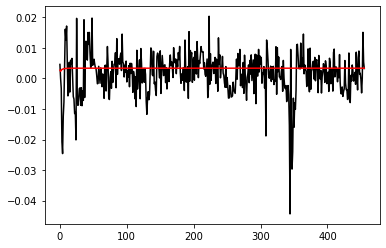

In [34]:
# plot predictions
# plot predictions
plt.plot(indpro_oos, color='black')
plt.plot(ar_pred.reset_index(drop=True), color='red')
plt.show()

### 2. Ridge Regression AR

This specification introduced regularization in the benchmark AR, where parameters are estimated with a ridge penalty. 

* Order of lag chosen from $p_y\in \{1,3,9,12,24\} $
* For each lag length, the Ridge hyperparameter is chosen through K-fold CV (RRAR,K-fold) and POOS-CV (RRAR,POOS-CV). 

The four main ML features for this specification are
1. Linear $g(.)$ function.
2. Ridge regularization.
3. Cross validation (POOS, K-fold) for Ridge hyperparameter selection.
4. Quadratic loss function.

The following function implements a Ridge AR regression, choosing the Ridge hyperparameter through cross-validation for each lag length. The lag length with the minimum root mean squared error is selected as the optimal lag length for the Ridge AR model. The function returns predictions for the optimal Ridge AR model along with the out-of-sample RMSE.

In [40]:
def ridgear_model_select(indpro_insample, indpro_oos, maxlags, alphas, cv, ss, tscv):
    """
    Inputs:
    indpro_insample: insample data for estimation
    indpro_oos: out-of-sample data for final evaluation
    maxlags: lag length for AR models
    alphas: Ridge penalty parameters
    cv: type of cross validation selected
    ss: indices for K-fold CV
    tscv: indices for pseudo out-of-sample CV
    
    Output:
    ridge_opt_pred: predictions for optimal Ridge AR model
    """
    
    indpro_insample_df = pd.DataFrame(indpro_insample)
    
    if cv == 'kfold':
#         alphas = np.linspace(0,4,6)
        ridge_kfold_lags = np.zeros((len(maxlags), 3))

        for i,lag in enumerate(maxlags):
            print(' ')
            print('Lag: ', lag)

            ## For each lag length, create X and y datasets for ridge regression
            for l in range(lag):
                indpro_insample_df[f'lag_{l+1}'] = indpro_insample_df['INDPRO'].shift(l+1)

            y = indpro_insample_df['INDPRO']
            X = indpro_insample_df.iloc[:,1:lag+1].fillna(0)

            ## Choose hyperparameter: alpha for Ridge regression
            ridge_kfold = np.zeros((len(alphas), ss.n_splits))

            for j, a in enumerate(alphas):
                fold=0
                print(' ')
                print('Alpha: ', a)
                ridge_model = Ridge(a, normalize=True)
                ridge_model.set_params(alpha=a)

                for train_idx, test_idx in ss.split(indpro_insample):
                    X_train, X_test = X.iloc[train_idx,:], X.iloc[test_idx,:]
                    y_train, y_test = y[train_idx], y[test_idx]

                    ridge_model.fit(X_train, y_train) # fit ridge on training data
                    ridge_pred = ridge_model.predict(X_test) # predict using test data

                    print('Test RMSE for fold ', fold+1, ' is ', sqrt(mean_squared_error(y_test, ridge_pred)))

                    ridge_kfold[j, fold] = sqrt(mean_squared_error(y_test, ridge_pred))
                    fold += 1

            kfold_alpha_min_idx = np.mean(ridge_kfold, axis=1).argmin()
            kfold_alpha_min = alphas[kfold_alpha_min_idx]
            print(' ')
            print('Optimal alpha for K-fold CV is: ', kfold_alpha_min)

            ridge_kfold_lags[i, 0] = lag
            ridge_kfold_lags[i, 1] = kfold_alpha_min
            ridge_kfold_lags[i, 2] = np.mean(ridge_kfold, axis=1)[kfold_alpha_min_idx]


        ## Optimal Ridge model
        kfold_opt_lag = int(ridge_kfold_lags[ridge_kfold_lags[:,2].argmin(),0])
        kfold_opt_alpha = ridge_kfold_lags[ridge_kfold_lags[:,2].argmin(),1]
        print('Optimal lag for K-fold CV is: ', kfold_opt_lag)

        indpro_insample_df = pd.DataFrame(indpro_insample)
        indpro_oos_df = pd.DataFrame(indpro_oos)
        for l in range(kfold_opt_lag):
            indpro_insample_df[f'lag_{l+1}'] = indpro_insample_df['INDPRO'].shift(l+1)
            indpro_oos_df[f'lag_{l+1}'] = indpro_oos_df['INDPRO'].shift(l+1)

        y_insample = indpro_insample_df['INDPRO']
        y_oos = indpro_oos_df['INDPRO']
        X_insample = indpro_insample_df.iloc[:,1:kfold_opt_lag+1].fillna(0)
        X_oos = indpro_oos_df.iloc[:,1:kfold_opt_lag+1].fillna(0)

        ridge_opt = Ridge(alpha=kfold_opt_alpha, normalize=True)
        ridge_opt.fit(X_insample, y_insample)
        ridge_opt_pred = ridge_opt.predict(X_oos)
        print('Out-of-sample RMSE for best Ridge K-fold model is ', sqrt(mean_squared_error(y_oos, ridge_opt_pred)))
        
        return ridge_opt_pred
    
    elif cv == 'poos':
#         alphas = np.linspace(0,4,6)
        ridge_poos_lags = np.zeros((len(maxlags), 3))

        for i,lag in enumerate(maxlags):
            print(' ')
            print('Lag: ', lag)

            ## For each lag length, create X and y datasets for ridge regression
            for l in range(lag):
                indpro_insample_df[f'lag_{l+1}'] = indpro_insample_df['INDPRO'].shift(l+1)

            y = indpro_insample_df['INDPRO']
            X = indpro_insample_df.iloc[:,1:lag+1].fillna(0)

            ## Choose hyperparameter: alpha for Ridge regression
            ridge_poos = np.zeros((len(alphas), tscv.n_splits))

            for j, a in enumerate(alphas):
                fold=0
                print(' ')
                print('Alpha: ', a)
                ridge_model = Ridge(a, normalize=True)
                ridge_model.set_params(alpha=a)

                for train_idx, test_idx in tscv.split(indpro_insample):
                    X_train, X_test = X.iloc[train_idx,:], X.iloc[test_idx,:]
                    y_train, y_test = y[train_idx], y[test_idx]

                    ridge_model.fit(X_train, y_train) # fit ridge on training data
                    ridge_pred = ridge_model.predict(X_test) # predict using test data

                    print('Test RMSE for fold ', fold+1, ' is ', sqrt(mean_squared_error(y_test, ridge_pred)))

                    ridge_poos[j, fold] = sqrt(mean_squared_error(y_test, ridge_pred))
                    fold += 1

            poos_alpha_min_idx = np.mean(ridge_poos, axis=1).argmin()
            poos_alpha_min = alphas[poos_alpha_min_idx]
            print(' ')
            print('Optimal alpha for POOS CV is: ', poos_alpha_min)

            ridge_poos_lags[i, 0] = lag
            ridge_poos_lags[i, 1] = poos_alpha_min
            ridge_poos_lags[i, 2] = np.mean(ridge_poos, axis=1)[poos_alpha_min_idx]


        ## Optimal Ridge model
        poos_opt_lag = int(ridge_poos_lags[ridge_poos_lags[:,2].argmin(),0])
        poos_opt_alpha = ridge_poos_lags[ridge_poos_lags[:,2].argmin(),1]
        print('Optimal lag for POOS CV is: ', poos_opt_lag)

        indpro_insample_df = pd.DataFrame(indpro_insample)
        indpro_oos_df = pd.DataFrame(indpro_oos)
        for l in range(poos_opt_lag):
            indpro_insample_df[f'lag_{l+1}'] = indpro_insample_df['INDPRO'].shift(l+1)
            indpro_oos_df[f'lag_{l+1}'] = indpro_oos_df['INDPRO'].shift(l+1)

        y_insample = indpro_insample_df['INDPRO']
        y_oos = indpro_oos_df['INDPRO']
        X_insample = indpro_insample_df.iloc[:,1:poos_opt_lag+1].fillna(0)
        X_oos = indpro_oos_df.iloc[:,1:poos_opt_lag+1].fillna(0)

        ridge_opt = Ridge(alpha=poos_opt_alpha, normalize=True)
        ridge_opt.fit(X_insample, y_insample)
        ridge_opt_pred = ridge_opt.predict(X_oos)
        print('Out-of-sample RMSE for best Ridge POOS model is ', sqrt(mean_squared_error(y_oos, ridge_opt_pred)))
        
        return ridge_opt_pred


#### Predictions

In [44]:
%%time

maxlags = [1, 3, 9, 12, 24]
# maxlags = [3]
alphas = np.linspace(0,4,6)
ridge_pred = ridgear_model_select(indpro_insample, indpro_oos, maxlags, alphas, 'poos', ss, tscv)

 
Lag:  1
 
Alpha:  0.0
Test RMSE for fold  1  is  0.007675270025651001
Test RMSE for fold  2  is  0.006901265517226728
Test RMSE for fold  3  is  0.008566956838692952
Test RMSE for fold  4  is  0.00979130350729377
Test RMSE for fold  5  is  0.0071187770184226685
 
Alpha:  0.8
Test RMSE for fold  1  is  0.0074637398913588475
Test RMSE for fold  2  is  0.006864831430292541
Test RMSE for fold  3  is  0.008761852738970339
Test RMSE for fold  4  is  0.010553109915009
Test RMSE for fold  5  is  0.006961735724200227
 
Alpha:  1.6
Test RMSE for fold  1  is  0.007427389820979794
Test RMSE for fold  2  is  0.006866078452369737
Test RMSE for fold  3  is  0.008851023809611634
Test RMSE for fold  4  is  0.010870460742131913
Test RMSE for fold  5  is  0.006959732593688389
 
Alpha:  2.4000000000000004
Test RMSE for fold  1  is  0.007418546258677717
Test RMSE for fold  2  is  0.006870177331112529
Test RMSE for fold  3  is  0.008901302132980092
Test RMSE for fold  4  is  0.011043310784690766
Test RMSE

In [45]:
ridge_pred

array([ 1.52449700e-03,  2.92723809e-03,  1.81726231e-03,  1.27332989e-03,
       -5.06259291e-03, -7.88687756e-03, -7.28742019e-03, -5.73444991e-03,
        7.54572460e-05,  5.40535237e-03,  6.98007490e-03,  1.02514220e-02,
        6.41411665e-03,  2.96412782e-03,  6.92890391e-04,  1.90711857e-03,
       -2.84593162e-04,  3.95381365e-03,  2.59921726e-03,  4.81915149e-03,
        2.67431837e-03,  7.69599108e-04, -9.51595577e-04, -3.43353644e-03,
       -3.69715076e-03, -7.27151324e-03,  4.48186529e-03, -2.96568511e-03,
        1.60340272e-03, -2.28670407e-03, -1.38678400e-03, -7.19493692e-04,
       -1.93901898e-03, -4.86179245e-04, -2.88681186e-03, -7.78283653e-04,
       -2.43831363e-03,  6.30451190e-03, -4.15931772e-04,  6.81684131e-03,
        4.71905927e-03,  5.72322509e-03,  5.80882881e-03,  7.65225035e-03,
        6.86696529e-03,  9.34095186e-03,  6.85592788e-03,  5.61758548e-03,
        4.74022569e-03,  8.50193639e-03,  4.94497482e-03,  6.59098010e-03,
        4.47038888e-03,  

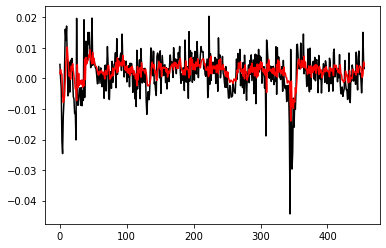

In [46]:
# plot predictions
plt.plot(indpro_oos, color='black')
plt.plot(ridge_pred, color='red')
plt.show()

### 3. Random Forest AR

In this specification non-linearities are introduced in the set of predictors. Tree-based methods are typically used to do this, splitting the set of predictors into dummy variables and their interactions. Since trees are prone to overfitting, the random forest method is applied.

* Order of lag chosen from $p_y\in \{1,3,9,12,24\} $
* This is the only hyperparameter in the model, chosen through K-fold CV (RFAR,K-fold) and POOS-CV (RFAR,POOS-CV). 
* Number of predictors in each tree is set to one-third of total number of predictors. 
* Observations in each set is sampled with replacement. 
* Number of trees selected internally with out-of-bag observations.

The four main ML features for this specification are
1. Non-linear $g(.)$ function.
2. No regularization.
3. Cross validation (POOS, K-fold) for lag length selection.
4. Quadratic loss function.

The function below implements a Random Forest AR regression, choosing the AR lag length through cross-validation. The number of trees for the RF model is selected through out-of-bag observations for each lag lenth. The lag length with the minimum root mean squared error is selected as the optimal lag length for the RF AR model. The function returns predictions for the optimal RF AR model along with the out-of-sample RMSE.

In [50]:
def rfar_model_select(indpro_insample, indpro_oos, maxlags, cv, ss, tscv):
    """
    Inputs:
    indpro_insample: insample data for estimation
    indpro_oos: out-of-sample data for final evaluation
    maxlags: lag length for AR models
    cv: type of cross validation selected
    ss: indices for K-fold CV
    tscv: indices for pseudo out-of-sample CV
    
    Output:
    rf_opt_pred: predictions for optimal Random Forest AR model
    """
    
    indpro_insample_df = pd.DataFrame(indpro_insample)
    indpro_oos_df = pd.DataFrame(indpro_oos)
    
    if cv == 'kfold':
        rf_rmse = np.zeros((len(maxlags), ss.n_splits))
        
        for i, lag in enumerate(maxlags):
            print('Lags: ', lag)

            # for each lag length, create lags of the variable. Split data into y and X
            for l in range(lag):
                indpro_insample_df[f'lag_{l+1}'] = indpro_insample_df['INDPRO'].shift(l+1)

            y = indpro_insample_df['INDPRO']
            X = indpro_insample_df.iloc[:,1:lag+1].fillna(0)

            ## Start cross-validation fold here 
            fold = 0

            for train_idx, test_idx in ss.split(indpro_insample):
                X_train, X_test = X.iloc[train_idx,:], X.iloc[test_idx,:]
                y_train, y_test = y[train_idx], y[test_idx]

                # Use out-of-bag observations to get the optimal number of trees
                min_estimators = 15
                max_estimators = 175
                estimators = list(range(min_estimators, max_estimators+1))

                error_rate = np.zeros(((len(estimators)), 2))

                rf_model = RandomForestRegressor(criterion='mse', 
                                                  max_features=0.33, 
                                                  oob_score=True, 
                                                  random_state=123, 
                                                  n_jobs=15)

                for j,n in enumerate(estimators):
                    rf_model.set_params(n_estimators=n)
                    rf_model.fit(X_train, y_train)
                    error_rate[j, 0] = n
                    error_rate[j, 1] = rf_model.oob_score_

                min_oob_error_idx = error_rate[:,1].argmin()
                opt_n_trees = error_rate[min_oob_error_idx, 0]
                print('Number of trees for lag ', lag, 'and fold ', fold+1, ' is ', opt_n_trees)

                # Using optimal number of trees for the lag length, run RF model and calculate RMSE
                rf_model.set_params(n_estimators=int(opt_n_trees))
                rf_model.fit(X_train, y_train)
                rf_pred = rf_model.predict(X_test)

                print('Test RMSE for fold ', fold+1, ' is ', sqrt(mean_squared_error(y_test, rf_pred)))
                rf_rmse[i, fold] = sqrt(mean_squared_error(y_test, rf_pred))
                fold += 1
            
        rf_opt_lag_idx = np.mean(rf_rmse, axis=1).argmin()
        rf_opt_lag = maxlags[rf_opt_lag_idx]

        for l in range(rf_opt_lag):
            indpro_insample_df[f'lag_{l+1}'] = indpro_insample_df['INDPRO'].shift(l+1)
            indpro_oos_df[f'lag_{l+1}'] = indpro_oos_df['INDPRO'].shift(l+1)

        y_insample = indpro_insample_df['INDPRO']
        X_insample = indpro_insample_df.iloc[:,1:rf_opt_lag+1].fillna(0)
        y_oos = indpro_oos_df['INDPRO']
        X_oos = indpro_oos_df.iloc[:,1:rf_opt_lag+1].fillna(0)

        min_estimators = 15
        max_estimators = 175
        estimators = list(range(min_estimators, max_estimators+1))

        error_rate = np.zeros(((len(estimators)), 2))

        rf_model = RandomForestRegressor(criterion='mse', 
                                          max_features=0.33, 
                                          oob_score=True, 
                                          random_state=123, 
                                          n_jobs=15)

        for j,n in enumerate(estimators):
            rf_model.set_params(n_estimators=n)
            rf_model.fit(X_insample, y_insample)
            error_rate[j, 0] = n
            error_rate[j, 1] = rf_model.oob_score_

        min_oob_error_idx = error_rate[:,1].argmin()
        opt_n_trees = error_rate[min_oob_error_idx, 0]
        print('Optimal number of trees for RF K-fold is ', opt_n_trees)
        print('Optimal lag for RF K-fold is ', rf_opt_lag)

        # Using optimal number of trees for the optimal lag length, run RF model and calculate RMSE
        rf_model.set_params(n_estimators=int(opt_n_trees))
        rf_model.fit(X_insample, y_insample)
        rf_pred_oos = rf_model.predict(X_oos)
        print('Out-of-sample RMSE for best RF K-fold model ', sqrt(mean_squared_error(y_oos, rf_pred_oos)))
        
        return rf_pred_oos
    
    if cv == 'poos':
        rf_rmse = np.zeros((len(maxlags), tscv.n_splits))
        
        for i, lag in enumerate(maxlags):
            print('Lags: ', lag)

            # for each lag length, create lags of the variable. Split data into y and X
            for l in range(lag):
                indpro_insample_df[f'lag_{l+1}'] = indpro_insample_df['INDPRO'].shift(l+1)

            y = indpro_insample_df['INDPRO']
            X = indpro_insample_df.iloc[:,1:lag+1].fillna(0)

            ## Start cross-validation fold here 
            fold = 0

            for train_idx, test_idx in tscv.split(indpro_insample):
                X_train, X_test = X.iloc[train_idx,:], X.iloc[test_idx,:]
                y_train, y_test = y[train_idx], y[test_idx]

                # Use out-of-bag observations to get the optimal number of trees
                min_estimators = 15
                max_estimators = 175
                estimators = list(range(min_estimators, max_estimators+1))

                error_rate = np.zeros(((len(estimators)), 2))

                rf_model = RandomForestRegressor(criterion='mse', 
                                                  max_features=0.33, 
                                                  oob_score=True, 
                                                  random_state=123, 
                                                  n_jobs=15)

                for j,n in enumerate(estimators):
                    rf_model.set_params(n_estimators=n)
                    rf_model.fit(X_train, y_train)
                    error_rate[j, 0] = n
                    error_rate[j, 1] = rf_model.oob_score_

                min_oob_error_idx = error_rate[:,1].argmin()
                opt_n_trees = error_rate[min_oob_error_idx, 0]
                print('Number of trees for lag ', lag, 'and fold ', fold+1, ' is ', opt_n_trees)

                # Using optimal number of trees for the lag length, run RF model and calculate RMSE
                rf_model.set_params(n_estimators=int(opt_n_trees))
                rf_model.fit(X_train, y_train)
                rf_pred = rf_model.predict(X_test)

                print('Test RMSE for fold ', fold+1, ' is ', sqrt(mean_squared_error(y_test, rf_pred)))
                rf_rmse[i, fold] = sqrt(mean_squared_error(y_test, rf_pred))
                fold += 1
            
        rf_opt_lag_idx = np.mean(rf_rmse, axis=1).argmin()
        rf_opt_lag = maxlags[rf_opt_lag_idx]

        for l in range(rf_opt_lag):
            indpro_insample_df[f'lag_{l+1}'] = indpro_insample_df['INDPRO'].shift(l+1)
            indpro_oos_df[f'lag_{l+1}'] = indpro_oos_df['INDPRO'].shift(l+1)

        y_insample = indpro_insample_df['INDPRO']
        X_insample = indpro_insample_df.iloc[:,1:rf_opt_lag+1].fillna(0)
        y_oos = indpro_oos_df['INDPRO']
        X_oos = indpro_oos_df.iloc[:,1:rf_opt_lag+1].fillna(0)

        min_estimators = 15
        max_estimators = 175
        estimators = list(range(min_estimators, max_estimators+1))

        error_rate = np.zeros(((len(estimators)), 2))

        rf_model = RandomForestRegressor(criterion='mse', 
                                          max_features=0.33, 
                                          oob_score=True, 
                                          random_state=123, 
                                          n_jobs=15)

        for j,n in enumerate(estimators):
            rf_model.set_params(n_estimators=n)
            rf_model.fit(X_insample, y_insample)
            error_rate[j, 0] = n
            error_rate[j, 1] = rf_model.oob_score_

        min_oob_error_idx = error_rate[:,1].argmin()
        opt_n_trees = error_rate[min_oob_error_idx, 0]
        print('Optimal number of trees for RF POOS is ', opt_n_trees)
        print('Optimal lag for RF POOS is ', rf_opt_lag)

        # Using optimal number of trees for the optimal lag length, run RF model and calculate RMSE
        rf_model.set_params(n_estimators=int(opt_n_trees))
        rf_model.fit(X_insample, y_insample)
        rf_pred_oos = rf_model.predict(X_oos)
        print('Out-of-sample RMSE for best RF POOS model ', sqrt(mean_squared_error(y_oos, rf_pred_oos)))
        
        return rf_pred_oos
        
    

#### Predictions

In [51]:
%%time

maxlags = [1, 3, 9, 12, 24]
# maxlags = [3]
rf_pred = rfar_model_select(indpro_insample, indpro_oos, maxlags, 'kfold', ss, tscv)

Lags:  1


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Number of trees for lag  1 and fold  1  is  68.0
Test RMSE for fold  1  is  0.010412956623237936


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Number of trees for lag  1 and fold  2  is  20.0
Test RMSE for fold  2  is  0.008645968968956115


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Number of trees for lag  1 and fold  3  is  15.0
Test RMSE for fold 

C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


 3  is  0.01090174710099246


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Number of trees for lag  1 and fold  4  is  15.0


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Test RMSE for fold  4  is  0.008409737114615002


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Number of trees for lag  1 and fold  5  is  28.0
Test RMSE for fold  5  is  0.008842459894732653
Lags:  3


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Number of trees for lag  3 and fold  1  is  15.0


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Test RMSE for fold  1  is  0.009299159064864228


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Number of trees for lag  3 and fold  2  is  24.0
Test RMSE for fold  2  is  0.007751810204186875


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Number of trees for lag  3 and fold  3  is  15.0


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Test RMSE for fold  3  is  0.010593489196148515


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Number of trees for lag  3 and fold  4  is  17.0


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Test RMSE for fold  4  is  0.008372407919637455


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Number of trees for lag  3 and fold  5  is  15.0


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Test RMSE for fold  5  is  0.008227957117841057
Lags:  9


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Number of trees for lag  9 and fold  1  is  15.0


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Test RMSE for fold  1  is  0.009867253928977573


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Number of trees for lag  9 and fold  2  is  15.0


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Test RMSE for fold  2  is  0.008826695437171909


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Number of trees for lag  9 and fold  3  is  15.0


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Test RMSE for fold  3  is  0.010019173858094307


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Number of trees for lag  9 and fold  4  is  15.0


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Test RMSE for fold  4  is  0.00795295003780516


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Number of trees for lag  9 and fold  5  is  15.0


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Test RMSE for fold  5  is  0.008706491483222393
Lags:  12


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Number of trees for lag  12 and fold  1  is  15.0


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Test RMSE for fold  1  is  0.010083514222675703


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Number of trees for lag  12 and fold  2  is  15.0


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Test RMSE for fold  2  is  0.00852721803673036


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Number of trees for lag  12 and fold  3  is  16.0


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Test RMSE for fold  3  is  0.010531577945669779


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Number of trees for lag  12 and fold  4  is  30.0
Test RMSE for fold  4  is  0.00775733336915203


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Number of trees for lag  12 and fold  5  is  18.0
Test RMSE for fold  5  is  0.00840423717169939
Lags:  24


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Number of trees for lag  24 and fold  1  is  15.0


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Test RMSE for fold  1  is  0.009485866919585579


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Number of trees for lag  24 and fold  2  is  15.0


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Test RMSE for fold  2  is  0.00874269327058876


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Number of trees for lag  24 and fold  3  is  15.0


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Test RMSE for fold  3  is  0.01045046956685297


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Number of trees for lag  24 and fold  4  is  15.0


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Test RMSE for fold  4  is  0.007609022618157051


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Number of trees for lag  24 and fold  5  is  16.0


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Test RMSE for fold  5  is  0.008866772468611051


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Optimal number of trees for RF K-fold is  15.0
Optimal lag for RF K-fold is  3
Out-of-sample RMSE for best RF K-fold model  0.007022543118434428
Wall time: 11min 54s


C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


In [52]:
rf_pred

array([ 1.55377322e-02,  4.42005115e-03,  8.36778035e-03,  4.32661011e-03,
       -6.92756744e-03, -5.12660753e-03, -5.91214934e-03, -4.81619896e-03,
       -8.13696736e-03,  6.13279933e-03,  4.54800860e-03,  1.00254281e-02,
        3.43458229e-03,  6.58162981e-03,  2.11855781e-03,  2.13485844e-03,
       -3.07889195e-04,  5.17970409e-03,  1.34395916e-03,  2.94278642e-03,
        4.85918953e-03,  7.69651752e-04, -1.66503866e-04, -2.61270662e-03,
       -6.08150427e-03, -1.00062941e-02,  1.55841251e-03,  1.75318905e-03,
        2.34269696e-04,  3.88746128e-04,  3.86765104e-05, -5.49502241e-04,
       -4.70161002e-03, -4.45811313e-03, -3.39988622e-03, -3.87848510e-03,
       -3.57806971e-03,  6.98396982e-03,  1.96951377e-03,  7.54750866e-03,
        4.84908693e-03,  2.30432776e-03,  6.89460969e-03,  7.07364966e-03,
        5.32734036e-03,  8.89395901e-03,  9.45845148e-04,  5.56570879e-03,
        3.02056419e-03,  8.41724481e-03,  3.53239237e-03,  3.46377005e-03,
        5.91078621e-03,  

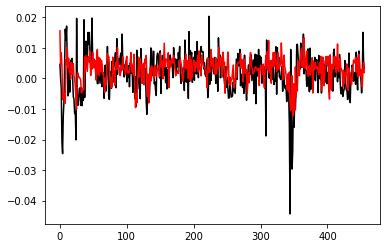

In [53]:
# plot predictions
plt.plot(indpro_oos, color='black')
plt.plot(rf_pred, color='red')
plt.show()

### 4. Kernel Ridge Regression AR

This specification combines the Ridge regression with a Kernel trick, which adds non-linear relationships to the set of predictors. Hyperparameters in this specification are

* Ridge penalty parameter
* Radial basis function (RBF) kernel tunining parameter
* Lag length $p_y\in\{1,3,9,12,24\}$ 

The four main ML features for this specification are
1. Non-linear $g(.)$ function.
2. Ridge regularization.
3. Cross validation (POOS, K-fold) for hyperparameter selection.
4. Quadratic loss function.

The following function implements a Kernel Ridge AR regression, choosing the Ridge parameter and RBF kernel tuning parameter through cross-validation for each lag length. The lag length with the minimum root mean squared error is selected as the optimal lag length for the model. The function returns predictions for the optimal Kernel Ridge AR model along with the out-of-sample RMSE.

In [69]:
def krrar_model_select(indpro_insample, indpro_oos, maxlags, alphas, gammas, cv, ss, tscv):
    """
    Inputs:
    indpro_insample: insample data for estimation
    indpro_oos: out-of-sample data for final evaluation
    maxlags: lag length for AR models
    alphas: Ridge penalty parameters
    gammas: RBF kernel tuning parameters
    cv: type of cross validation selected
    ss: indices for K-fold CV
    tscv: indices for pseudo out-of-sample CV
    
    Output:
    ridge_opt_pred: predictions for optimal Ridge AR model
    """
    
    indpro_insample_df = pd.DataFrame(indpro_insample)
    indpro_oos_df = pd.DataFrame(indpro_oos)
    
    if cv == 'kfold':
        krr_lags = np.zeros((len(maxlags), 4))

        for i,lag in enumerate(maxlags):
            print(' ')
            print('Lag: ', lag)

            ## For each lag length, create X and y datasets for ridge regression
            for l in range(lag):
                indpro_insample_df[f'lag_{l+1}'] = indpro_insample_df['INDPRO'].shift(l+1)

            y = indpro_insample_df['INDPRO']
            X = indpro_insample_df.iloc[:,1:lag+1].fillna(0)

            ## Choose hyperparameter: alpha for Ridge regression penalty, gamma for RBF tuning parameter
            krr_folds = np.zeros((len(alphas)*len(gammas), ss.n_splits+2))
            row = 0

            for j, a in enumerate(alphas):
                print(' ')
                print('Alpha: ', a)

                for k, g in enumerate(gammas):
                    fold=0
                    print('\n Gamma:', g)

                    krr_model = KernelRidge(alpha=a, kernel='rbf', gamma=g)

                    for train_idx, test_idx in ss.split(indpro_insample):
                        X_train, X_test = X.iloc[train_idx,:], X.iloc[test_idx,:]
                        y_train, y_test = y[train_idx], y[test_idx]

                        krr_model.fit(X_train, y_train) # fit ridge on training data
                        krr_pred = krr_model.predict(X_test) # predict using test data

                        print('Test RMSE for fold ', fold+1, ' is ', sqrt(mean_squared_error(y_test, krr_pred)))

                        krr_folds[row, 0] = a
                        krr_folds[row, 1] = g
                        krr_folds[row, fold+2] = sqrt(mean_squared_error(y_test, krr_pred))
                        fold += 1

                    row+= 1
                    
            krr_para_min_idx = np.mean(krr_folds[:,2:6], axis=1).argmin()
            print(' ')

            krr_lags[i, 0] = lag
            krr_lags[i, 1] = krr_folds[krr_para_min_idx,0]
            krr_lags[i, 2] = krr_folds[krr_para_min_idx,1]
            krr_lags[i, 3] = np.mean(krr_folds[:,2:6], axis=1)[krr_para_min_idx]


        ## Optimal KRR model
        krr_opt_lag = int(krr_lags[krr_lags[:,3].argmin(),0])
        krr_opt_alpha = krr_lags[krr_lags[:,3].argmin(),1]
        krr_opt_gamma = krr_lags[krr_lags[:,3].argmin(),2]
        print('Optimal lag for K-fold CV is: ', krr_opt_lag)
        print('Optimal alpha for K-fold CV is: ', krr_opt_alpha)
        print('Optimal gamma for K-fold CV is: ', krr_opt_gamma)

        for l in range(krr_opt_lag):
            indpro_insample_df[f'lag_{l+1}'] = indpro_insample_df['INDPRO'].shift(l+1)
            indpro_oos_df[f'lag_{l+1}'] = indpro_oos_df['INDPRO'].shift(l+1)

        y_insample = indpro_insample_df['INDPRO']
        y_oos = indpro_oos_df['INDPRO']
        X_insample = indpro_insample_df.iloc[:,1:krr_opt_lag+1].fillna(0)
        X_oos = indpro_oos_df.iloc[:,1:krr_opt_lag+1].fillna(0)

        krr_opt = KernelRidge(alpha=krr_opt_alpha, kernel='rbf', gamma=krr_opt_gamma)
        krr_opt.fit(X_insample, y_insample)
        krr_opt_pred = krr_opt.predict(X_oos)
        print('Out-of-sample RMSE for best KRR K-fold model is ', sqrt(mean_squared_error(y_oos, krr_opt_pred)))
        
        return krr_opt_pred
    
    elif cv == 'poos':
        krr_lags = np.zeros((len(maxlags), 4))

        for i,lag in enumerate(maxlags):
            print(' ')
            print('Lag: ', lag)

            ## For each lag length, create X and y datasets for ridge regression
            for l in range(lag):
                indpro_insample_df[f'lag_{l+1}'] = indpro_insample_df['INDPRO'].shift(l+1)

            y = indpro_insample_df['INDPRO']
            X = indpro_insample_df.iloc[:,1:lag+1].fillna(0)

            ## Choose hyperparameter: alpha for Ridge regression penalty, gamma for RBF tuning parameter
            krr_folds = np.zeros((len(alphas)*len(gammas), tscv.n_splits+2))
            row = 0

            for j, a in enumerate(alphas):
                print(' ')
                print('Alpha: ', a)

                for k, g in enumerate(gammas):
                    fold=0
                    print('\n Gamma:', g)

                    krr_model = KernelRidge(alpha=a, kernel='rbf', gamma=g)

                    for train_idx, test_idx in tscv.split(indpro_insample):
                        X_train, X_test = X.iloc[train_idx,:], X.iloc[test_idx,:]
                        y_train, y_test = y[train_idx], y[test_idx]

                        krr_model.fit(X_train, y_train) # fit ridge on training data
                        krr_pred = krr_model.predict(X_test) # predict using test data

                        print('Test RMSE for fold ', fold+1, ' is ', sqrt(mean_squared_error(y_test, krr_pred)))

                        krr_folds[row, 0] = a
                        krr_folds[row, 1] = g
                        krr_folds[row, fold+2] = sqrt(mean_squared_error(y_test, krr_pred))
                        fold += 1

                    row+= 1
                    
            krr_para_min_idx = np.mean(krr_folds[:,2:6], axis=1).argmin()
            
            krr_lags[i, 0] = lag
            krr_lags[i, 1] = krr_folds[krr_para_min_idx,0]
            krr_lags[i, 2] = krr_folds[krr_para_min_idx,1]
            krr_lags[i, 3] = np.mean(krr_folds[:,2:6], axis=1)[krr_para_min_idx]


        ## Optimal KRR model
        krr_opt_lag = int(krr_lags[krr_lags[:,3].argmin(),0])
        krr_opt_alpha = krr_lags[krr_lags[:,3].argmin(),1]
        krr_opt_gamma = krr_lags[krr_lags[:,3].argmin(),2]
        print(' ')
        print('Optimal lag for POOS CV is: ', krr_opt_lag)
        print('Optimal alpha for POOS CV is: ', krr_opt_alpha)
        print('Optimal gamma for POOS CV is: ', krr_opt_gamma)

        for l in range(krr_opt_lag):
            indpro_insample_df[f'lag_{l+1}'] = indpro_insample_df['INDPRO'].shift(l+1)
            indpro_oos_df[f'lag_{l+1}'] = indpro_oos_df['INDPRO'].shift(l+1)

        y_insample = indpro_insample_df['INDPRO']
        y_oos = indpro_oos_df['INDPRO']
        X_insample = indpro_insample_df.iloc[:,1:krr_opt_lag+1].fillna(0)
        X_oos = indpro_oos_df.iloc[:,1:krr_opt_lag+1].fillna(0)

        krr_opt = KernelRidge(alpha=krr_opt_alpha, kernel='rbf', gamma=krr_opt_gamma)
        krr_opt.fit(X_insample, y_insample)
        krr_opt_pred = krr_opt.predict(X_oos)
        print('Out-of-sample RMSE for best KRR POOS model is ', sqrt(mean_squared_error(y_oos, krr_opt_pred)))
        
        return krr_opt_pred

#### Predictions

In [70]:
%%time 

maxlags = [1,3,9,12,24]
alphas = np.linspace(0,4,6)
gammas = np.logspace(-2,2,5)

krr_pred = krrar_model_select(indpro_insample, indpro_oos, maxlags, alphas, gammas, 'poos', ss, tscv)

 
Lag:  1
 
Alpha:  0.0

 Gamma: 0.01
Test RMSE for fold  1  is  0.008088109467336294
Test RMSE for fold  2  is  0.009068653491732612
Test RMSE for fold  3  is  0.008771247905527087
Test RMSE for fold  4  is  0.010055184244603874
Test RMSE for fold  5  is  0.007499015522639362

 Gamma: 0.1
Test RMSE for fold  1  is  0.008717720891440125
Test RMSE for fold  2  is  0.007812589105812413
Test RMSE for fold  3  is  0.00856424859399338
Test RMSE for fold  4  is  0.008833798435334338
Test RMSE for fold  5  is  0.007376820974362738

 Gamma: 1.0
Test RMSE for fold  1  is  0.009539346250068767
Test RMSE for fold  2  is  0.0069771778670681016
Test RMSE for fold  3  is  0.00887583544026386
Test RMSE for fold  4  is  0.009278733014860326
Test RMSE for fold  5  is  0.007143402269835617

 Gamma: 10.0
Test RMSE for fold  1  is  0.016008542251116982
Test RMSE for fold  2  is  0.006987034002775048
Test RMSE for fold  3  is  0.008694740767683418
Test RMSE for fold  4  is  0.01280424963954927
Test RMSE fo

C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\U

Test RMSE for fold  3  is  0.00907508023937916
Test RMSE for fold  4  is  0.01160943471632497
Test RMSE for fold  5  is  0.007075513150908635

 Gamma: 1.0
Test RMSE for fold  1  is  0.0074947540720986475
Test RMSE for fold  2  is  0.006871548194036237
Test RMSE for fold  3  is  0.00906952705216119
Test RMSE for fold  4  is  0.011583833858093527
Test RMSE for fold  5  is  0.007066610501612074

 Gamma: 10.0
Test RMSE for fold  1  is  0.00748613850014659
Test RMSE for fold  2  is  0.006863769515748458
Test RMSE for fold  3  is  0.009019869684920297
Test RMSE for fold  4  is  0.011362434672737249
Test RMSE for fold  5  is  0.007006846478517948

 Gamma: 100.0
Test RMSE for fold  1  is  0.007467754407670317
Test RMSE for fold  2  is  0.006841714615545387
Test RMSE for fold  3  is  0.008792332122395434
Test RMSE for fold  4  is  0.010505550429969162
Test RMSE for fold  5  is  0.007002143015220481
 
Alpha:  2.4000000000000004

 Gamma: 0.01
Test RMSE for fold  1  is  0.007522795452244424
Test R

C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\U

Test RMSE for fold  5  is  0.007073358565607414

 Gamma: 1.0
Test RMSE for fold  1  is  0.007457206203414236
Test RMSE for fold  2  is  0.006879131735996387
Test RMSE for fold  3  is  0.009055262489926394
Test RMSE for fold  4  is  0.011507985449104906
Test RMSE for fold  5  is  0.007057489796156662

 Gamma: 10.0
Test RMSE for fold  1  is  0.007380356530415455
Test RMSE for fold  2  is  0.006834588994546446
Test RMSE for fold  3  is  0.008913467696872223
Test RMSE for fold  4  is  0.010828722688204591
Test RMSE for fold  5  is  0.00701724096408547

 Gamma: 100.0
Test RMSE for fold  1  is  0.007223457905942409
Test RMSE for fold  2  is  0.006776564151354906
Test RMSE for fold  3  is  0.008672675430394388
Test RMSE for fold  4  is  0.0097053848840304
Test RMSE for fold  5  is  0.00709651283854265
 
Alpha:  1.6

 Gamma: 0.01
Test RMSE for fold  1  is  0.007495803537328149
Test RMSE for fold  2  is  0.006872522257869667
Test RMSE for fold  3  is  0.00907559091559152
Test RMSE for fold  4  

C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\U

Test RMSE for fold  1  is  0.04055631972624537
Test RMSE for fold  2  is  0.02044504188317059
Test RMSE for fold  3  is  0.053847608887134746
Test RMSE for fold  4  is  0.14665920558474937
Test RMSE for fold  5  is  0.03796764394321973

 Gamma: 100.0
Test RMSE for fold  1  is  0.029852835958251524
Test RMSE for fold  2  is  0.01838503790672073
Test RMSE for fold  3  is  0.04710630204045826
Test RMSE for fold  4  is  0.11239222044038322
Test RMSE for fold  5  is  0.02693469619704446
 
Alpha:  0.8

 Gamma: 0.01
Test RMSE for fold  1  is  0.007467991694971172
Test RMSE for fold  2  is  0.006885804845294826
Test RMSE for fold  3  is  0.00907690132332776
Test RMSE for fold  4  is  0.01161770253779614
Test RMSE for fold  5  is  0.007075155635331902

 Gamma: 0.1
Test RMSE for fold  1  is  0.007466127976014813
Test RMSE for fold  2  is  0.00688469134961276
Test RMSE for fold  3  is  0.009073861716640257
Test RMSE for fold  4  is  0.011604691131254022
Test RMSE for fold  5  is  0.00707276739754

C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=7.02238e-17): result may not be accurate.
  overwrite_a=False)
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages

Test RMSE for fold  4  is  0.011605020902390175
Test RMSE for fold  5  is  0.0070753784034559754

 Gamma: 1.0
Test RMSE for fold  1  is  0.007492462841918416
Test RMSE for fold  2  is  0.006864917293553802
Test RMSE for fold  3  is  0.009061914420302313
Test RMSE for fold  4  is  0.01154180415194895
Test RMSE for fold  5  is  0.007066039365512875

 Gamma: 10.0
Test RMSE for fold  1  is  0.0074688620610391405
Test RMSE for fold  2  is  0.006805805664876327
Test RMSE for fold  3  is  0.008967496208893262
Test RMSE for fold  4  is  0.011086578646164249
Test RMSE for fold  5  is  0.007034316031884564

 Gamma: 100.0
Test RMSE for fold  1  is  0.007425154540688526
Test RMSE for fold  2  is  0.006592827550885421
Test RMSE for fold  3  is  0.00877868126213577
Test RMSE for fold  4  is  0.010122281945680005
Test RMSE for fold  5  is  0.007206504846937717
 
Alpha:  2.4000000000000004

 Gamma: 0.01
Test RMSE for fold  1  is  0.0075227787643230275
Test RMSE for fold  2  is  0.006859676636572685
Te

Test RMSE for fold  2  is  0.006822593533119594
Test RMSE for fold  3  is  0.008908967005840304
Test RMSE for fold  4  is  0.010190910239028671
Test RMSE for fold  5  is  0.006942333242723439
 
Alpha:  3.2

 Gamma: 0.01
Test RMSE for fold  1  is  0.00754901476494798
Test RMSE for fold  2  is  0.00684740956071814
Test RMSE for fold  3  is  0.009072875108146016
Test RMSE for fold  4  is  0.011598548107096136
Test RMSE for fold  5  is  0.007078701034320341

 Gamma: 0.1
Test RMSE for fold  1  is  0.007548781642221746
Test RMSE for fold  2  is  0.006847352371738061
Test RMSE for fold  3  is  0.009072437297640056
Test RMSE for fold  4  is  0.011595023746098458
Test RMSE for fold  5  is  0.007077605067776928

 Gamma: 1.0
Test RMSE for fold  1  is  0.007546473838606063
Test RMSE for fold  2  is  0.006846783851159048
Test RMSE for fold  3  is  0.009068132930103792
Test RMSE for fold  4  is  0.011560507550079742
Test RMSE for fold  5  is  0.00706703719071358

 Gamma: 10.0
Test RMSE for fold  1  

In [67]:
krr_pred

array([ 1.38565041e-03,  2.57616717e-03,  1.74739400e-03,  1.11176705e-03,
       -3.74382177e-03, -7.24198631e-03, -6.98437284e-03, -6.46111907e-03,
       -1.20165264e-03,  5.33290474e-03,  6.13811224e-03,  9.17881028e-03,
        6.73206258e-03,  1.92425222e-03,  2.06036722e-03,  1.90499815e-03,
       -6.23693658e-04,  4.15473436e-03,  3.37570356e-03,  3.33443415e-03,
        3.89265396e-03,  1.14354554e-03, -1.15403409e-03, -2.41981107e-03,
       -4.42275550e-03, -6.24629655e-03,  2.28104974e-03, -1.75710860e-03,
       -3.87997764e-04,  1.03993793e-03, -2.81754887e-03, -1.82735628e-03,
       -5.36301675e-04, -2.88795481e-03, -1.20315100e-03, -1.72228132e-03,
       -2.13758380e-03,  4.31282101e-03,  1.06334282e-04,  4.85894396e-03,
        6.28334640e-03,  2.91888202e-03,  5.26688848e-03,  8.34906674e-03,
        3.63088181e-03,  8.98321212e-03,  7.16012418e-03,  5.37086316e-03,
        6.13265376e-03,  7.65546993e-03,  4.45179449e-03,  6.77203870e-03,
        6.46675886e-03,  

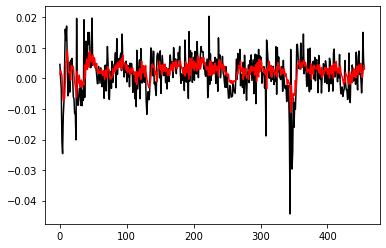

In [68]:
# plot predictions
plt.plot(indpro_oos, color='black')
plt.plot(krr_pred, color='red')
plt.show()

### 5. Support Vector Regression AR

All previous specifications used a quadratic loss function while minimising sum of squared errors to obtain estimators. This specification utilizes a $\epsilon$-insensitive loss function instead. SVR is differs from the other AR models in the followings ways
* different in-sample loss function.
* non-linearities using a kernel trick.
* different tuning parameters. 

To isolate the effects of the loss function from the non-linearities, a linear SVR model (SVR-AR,Lin) needs to be implemented along with the RBF kernel SVR (SVR-AR,RBF). 

Hyperparameters in this specification are

* Size of the insensitivity tube of the loss function. No penalties are associated in the training loss function within this tube. 
* Ridge penalty parameter.
* RBF kernel tuning parameter.
* Lag length $p_y\in\{1,3,9,12,24\}$.

The four main ML features for this specification are
1. Linear $g(.)$ function for SVR-AR,Lin model. Non-linear $g(.)$ function for SVR-AR,RBF model.
2. Ridge regularization.
3. Cross validation (POOS, K-fold) for hyperparameter selection.
4. $\epsilon$-insensitive loss function.

The function below implements a SVR AR regression, choosing the Ridge parameter, RBF kernel tuning parameter and insensitivity parameter through cross-validation for each lag length. The cross-validation method is speficied by the user along with the kernel to use (linear/rbf) for the SVR method. The lag length with the minimum root mean squared error is selected as the optimal lag length for the specified model. The function returns predictions for the optimal SVR AR model along with the out-of-sample RMSE.

In [73]:
def svrar_model_select(indpro_insample, indpro_oos, maxlags, alphas, gammas, epsilons, kernel, cv, ss, tscv):
    """
    Inputs:
    indpro_insample: insample data for estimation
    indpro_oos: out-of-sample data for final evaluation
    maxlags: lag length for AR models
    alphas: Ridge penalty parameters
    gammas: RBF kernel tuning parameters
    epsilons: size of insensitivity tube
    kernel: type of kernel for SVR, linear or RBF
    cv: type of cross validation selected
    ss: indices for K-fold CV
    tscv: indices for pseudo out-of-sample CV
    
    Output:
    svr_opt_pred: predictions for optimal Ridge AR model
    """
    
    indpro_insample_df = pd.DataFrame(indpro_insample)
    indpro_oos_df = pd.DataFrame(indpro_oos)
    
    if cv == 'kfold':
        svr_lags = np.zeros((len(maxlags), 5))

        for i,lag in enumerate(maxlags):
            print(' ')
            print('Lag: ', lag)

            ## For each lag length, create X and y datasets for svr regression
            for l in range(lag):
                indpro_insample_df[f'lag_{l+1}'] = indpro_insample_df['INDPRO'].shift(l+1)

            y = indpro_insample_df['INDPRO']
            X = indpro_insample_df.iloc[:,1:lag+1].fillna(0)

            ## Choose hyperparameter: alpha for Ridge regression penalty, gamma for RBF tuning parameter, epsilon for loss function
            svr_folds = np.zeros((len(alphas)*len(gammas)*len(epsilons), ss.n_splits+3))
            row = 0

            for j, a in enumerate(alphas):
                print(' ')
                print('Alpha: ', a)

                for k, g in enumerate(gammas):
                    print('\n Gamma:', g)

                    for m, e in enumerate(epsilons):
                        fold=0
                        print('\n Epsilon:', e)

                        svr_model = SVR(kernel=kernel, C=a, gamma=g, epsilon=e)

                        for train_idx, test_idx in ss.split(indpro_insample):
                            X_train, X_test = X.iloc[train_idx,:], X.iloc[test_idx,:]
                            y_train, y_test = y[train_idx], y[test_idx]

                            svr_model.fit(X_train, y_train) # fit ridge on training data
                            svr_pred = svr_model.predict(X_test) # predict using test data

                            print('Test RMSE for fold ', fold+1, ' is ', sqrt(mean_squared_error(y_test, svr_pred)))

                            svr_folds[row, 0] = a
                            svr_folds[row, 1] = g
                            svr_folds[row, 2] = e
                            svr_folds[row, fold+3] = sqrt(mean_squared_error(y_test, svr_pred))
                            fold += 1

                        row+= 1
                    
            svr_para_min_idx = np.mean(svr_folds[:,3:7], axis=1).argmin()
            print(' ')

            svr_lags[i, 0] = lag
            svr_lags[i, 1] = svr_folds[svr_para_min_idx,0]
            svr_lags[i, 2] = svr_folds[svr_para_min_idx,1]
            svr_lags[i, 3] = svr_folds[svr_para_min_idx,2]
            svr_lags[i, 4] = np.mean(svr_folds[:,3:7], axis=1)[svr_para_min_idx]


        ## Optimal SVR model
        svr_opt_lag = int(svr_lags[svr_lags[:,4].argmin(),0])
        svr_opt_alpha = svr_lags[svr_lags[:,4].argmin(),1]
        svr_opt_gamma = svr_lags[svr_lags[:,4].argmin(),2]
        svr_opt_epsilon = svr_lags[svr_lags[:,4].argmin(),3]
        print('Optimal lag for K-fold CV is: ', svr_opt_lag)
        print('Optimal alpha for K-fold CV is: ', svr_opt_alpha)
        print('Optimal gamma for K-fold CV is: ', svr_opt_gamma)
        print('Optimal gamma for K-fold CV is: ', svr_opt_epsilon)

        for l in range(svr_opt_lag):
            indpro_insample_df[f'lag_{l+1}'] = indpro_insample_df['INDPRO'].shift(l+1)
            indpro_oos_df[f'lag_{l+1}'] = indpro_oos_df['INDPRO'].shift(l+1)

        y_insample = indpro_insample_df['INDPRO']
        y_oos = indpro_oos_df['INDPRO']
        X_insample = indpro_insample_df.iloc[:,1:svr_opt_lag+1].fillna(0)
        X_oos = indpro_oos_df.iloc[:,1:svr_opt_lag+1].fillna(0)

        svr_opt = SVR(kernel=kernel, C=svr_opt_alpha, gamma=svr_opt_gamma, epsilon=svr_opt_epsilon)
        svr_opt.fit(X_insample, y_insample)
        svr_opt_pred = svr_opt.predict(X_oos)
        print('Out-of-sample RMSE for best SVR K-fold model is ', sqrt(mean_squared_error(y_oos, svr_opt_pred)))
        
        return svr_opt_pred
    
    elif cv == 'poos':
        svr_lags = np.zeros((len(maxlags), 5))

        for i,lag in enumerate(maxlags):
            print(' ')
            print('Lag: ', lag)

            ## For each lag length, create X and y datasets for svr regression
            for l in range(lag):
                indpro_insample_df[f'lag_{l+1}'] = indpro_insample_df['INDPRO'].shift(l+1)

            y = indpro_insample_df['INDPRO']
            X = indpro_insample_df.iloc[:,1:lag+1].fillna(0)

            ## Choose hyperparameter: alpha for Ridge regression penalty, gamma for RBF tuning parameter, epsilon for loss function
            svr_folds = np.zeros((len(alphas)*len(gammas)*len(epsilons), tscv.n_splits+3))
            row = 0

            for j, a in enumerate(alphas):
                print(' ')
                print('Alpha: ', a)

                for k, g in enumerate(gammas):
                    print('\n Gamma:', g)

                    for m, e in enumerate(epsilons):
                        fold=0
                        print('\n Epsilon:', e)

                        svr_model = SVR(kernel=kernel, C=a, gamma=g, epsilon=e)

                        for train_idx, test_idx in tscv.split(indpro_insample):
                            X_train, X_test = X.iloc[train_idx,:], X.iloc[test_idx,:]
                            y_train, y_test = y[train_idx], y[test_idx]

                            svr_model.fit(X_train, y_train) # fit ridge on training data
                            svr_pred = svr_model.predict(X_test) # predict using test data

                            print('Test RMSE for fold ', fold+1, ' is ', sqrt(mean_squared_error(y_test, svr_pred)))

                            svr_folds[row, 0] = a
                            svr_folds[row, 1] = g
                            svr_folds[row, 2] = e
                            svr_folds[row, fold+3] = sqrt(mean_squared_error(y_test, svr_pred))
                            fold += 1

                        row+= 1
                    
            svr_para_min_idx = np.mean(svr_folds[:,3:7], axis=1).argmin()
            print(' ')

            svr_lags[i, 0] = lag
            svr_lags[i, 1] = svr_folds[svr_para_min_idx,0]
            svr_lags[i, 2] = svr_folds[svr_para_min_idx,1]
            svr_lags[i, 3] = svr_folds[svr_para_min_idx,2]
            svr_lags[i, 4] = np.mean(svr_folds[:,3:7], axis=1)[svr_para_min_idx]


        ## Optimal SVR model
        svr_opt_lag = int(svr_lags[svr_lags[:,4].argmin(),0])
        svr_opt_alpha = svr_lags[svr_lags[:,4].argmin(),1]
        svr_opt_gamma = svr_lags[svr_lags[:,4].argmin(),2]
        svr_opt_epsilon = svr_lags[svr_lags[:,4].argmin(),3]
        print('Optimal lag for POOS CV is: ', svr_opt_lag)
        print('Optimal alpha for POOS CV is: ', svr_opt_alpha)
        print('Optimal gamma for POOS CV is: ', svr_opt_gamma)
        print('Optimal gamma for POOS CV is: ', svr_opt_epsilon)

        for l in range(svr_opt_lag):
            indpro_insample_df[f'lag_{l+1}'] = indpro_insample_df['INDPRO'].shift(l+1)
            indpro_oos_df[f'lag_{l+1}'] = indpro_oos_df['INDPRO'].shift(l+1)

        y_insample = indpro_insample_df['INDPRO']
        y_oos = indpro_oos_df['INDPRO']
        X_insample = indpro_insample_df.iloc[:,1:svr_opt_lag+1].fillna(0)
        X_oos = indpro_oos_df.iloc[:,1:svr_opt_lag+1].fillna(0)

        svr_opt = SVR(kernel=kernel, C=svr_opt_alpha, gamma=svr_opt_gamma, epsilon=svr_opt_epsilon)
        svr_opt.fit(X_insample, y_insample)
        svr_opt_pred = svr_opt.predict(X_oos)
        print('Out-of-sample RMSE for best SVR POOS model is ', sqrt(mean_squared_error(y_oos, svr_opt_pred)))
        
        return svr_opt_pred

#### Predictions

In [77]:
%%time 

maxlags = [1,3,9,12,24]
alphas = np.linspace(0.1,4,6)
gammas = np.logspace(-2,2,5)
epsilons = np.logspace(-2,2,5)

svr_pred = svrar_model_select(indpro_insample, indpro_oos, maxlags, alphas, gammas, epsilons, 'rbf', 'poos', ss, tscv)

 
Lag:  1
 
Alpha:  0.1

 Gamma: 0.01

 Epsilon: 0.01
Test RMSE for fold  1  is  0.008142523847675637
Test RMSE for fold  2  is  0.006663449230168084
Test RMSE for fold  3  is  0.009072560555675825
Test RMSE for fold  4  is  0.011414039978909149
Test RMSE for fold  5  is  0.007164836986544547

 Epsilon: 0.1
Test RMSE for fold  1  is  0.00732100441187478
Test RMSE for fold  2  is  0.007164884241178593
Test RMSE for fold  3  is  0.009281232832670233
Test RMSE for fold  4  is  0.012065478425660654
Test RMSE for fold  5  is  0.009651873560252225

 Epsilon: 1.0
Test RMSE for fold  1  is  0.00732100441187478
Test RMSE for fold  2  is  0.007164884241178593
Test RMSE for fold  3  is  0.009281232832670233
Test RMSE for fold  4  is  0.012065478425660654
Test RMSE for fold  5  is  0.009651873560252225

 Epsilon: 10.0
Test RMSE for fold  1  is  0.007321004411874583
Test RMSE for fold  2  is  0.007164884241178506
Test RMSE for fold  3  is  0.009281232832670183
Test RMSE for fold  4  is  0.012065478

Test RMSE for fold  1  is  0.00732100441187478
Test RMSE for fold  2  is  0.007164884241178593
Test RMSE for fold  3  is  0.009281232832670233
Test RMSE for fold  4  is  0.012065478425660654
Test RMSE for fold  5  is  0.009651873560252225

 Epsilon: 10.0
Test RMSE for fold  1  is  0.007321004411874583
Test RMSE for fold  2  is  0.007164884241178506
Test RMSE for fold  3  is  0.009281232832670183
Test RMSE for fold  4  is  0.012065478425660558
Test RMSE for fold  5  is  0.009651873560252681

 Epsilon: 100.0
Test RMSE for fold  1  is  0.007321004411875369
Test RMSE for fold  2  is  0.00716488424117781
Test RMSE for fold  3  is  0.009281232832669802
Test RMSE for fold  4  is  0.012065478425658646
Test RMSE for fold  5  is  0.009651873560253894

 Gamma: 1.0

 Epsilon: 0.01
Test RMSE for fold  1  is  0.007722689082682121
Test RMSE for fold  2  is  0.00661405531760142
Test RMSE for fold  3  is  0.009000757500743584
Test RMSE for fold  4  is  0.010924681278205447
Test RMSE for fold  5  is  0.

Test RMSE for fold  1  is  0.007321004411875369
Test RMSE for fold  2  is  0.00716488424117781
Test RMSE for fold  3  is  0.009281232832669802
Test RMSE for fold  4  is  0.012065478425658646
Test RMSE for fold  5  is  0.009651873560253894

 Gamma: 10.0

 Epsilon: 0.01
Test RMSE for fold  1  is  0.008538375167454114
Test RMSE for fold  2  is  0.006643182281641311
Test RMSE for fold  3  is  0.008765845801112483
Test RMSE for fold  4  is  0.010728182373947551
Test RMSE for fold  5  is  0.007184122694309059

 Epsilon: 0.1
Test RMSE for fold  1  is  0.00732100441187478
Test RMSE for fold  2  is  0.007164884241178593
Test RMSE for fold  3  is  0.009281232832670233
Test RMSE for fold  4  is  0.012065478425660654
Test RMSE for fold  5  is  0.009651873560252225

 Epsilon: 1.0
Test RMSE for fold  1  is  0.00732100441187478
Test RMSE for fold  2  is  0.007164884241178593
Test RMSE for fold  3  is  0.009281232832670233
Test RMSE for fold  4  is  0.012065478425660654
Test RMSE for fold  5  is  0.00

Test RMSE for fold  5  is  0.009651873560252225

 Epsilon: 1.0
Test RMSE for fold  1  is  0.00732100441187478
Test RMSE for fold  2  is  0.007164884241178593
Test RMSE for fold  3  is  0.009281232832670233
Test RMSE for fold  4  is  0.012065478425660654
Test RMSE for fold  5  is  0.009651873560252225

 Epsilon: 10.0
Test RMSE for fold  1  is  0.007321004411874583
Test RMSE for fold  2  is  0.007164884241178506
Test RMSE for fold  3  is  0.009281232832670183
Test RMSE for fold  4  is  0.012065478425660558
Test RMSE for fold  5  is  0.009651873560252681

 Epsilon: 100.0
Test RMSE for fold  1  is  0.007321004411875369
Test RMSE for fold  2  is  0.00716488424117781
Test RMSE for fold  3  is  0.009281232832669802
Test RMSE for fold  4  is  0.012065478425658646
Test RMSE for fold  5  is  0.009651873560253894

 Gamma: 10.0

 Epsilon: 0.01
Test RMSE for fold  1  is  0.008461044727920291
Test RMSE for fold  2  is  0.006642938547373904
Test RMSE for fold  3  is  0.00871998997261467
Test RMSE for

Test RMSE for fold  1  is  0.007321004411875369
Test RMSE for fold  2  is  0.00716488424117781
Test RMSE for fold  3  is  0.009281232832669802
Test RMSE for fold  4  is  0.012065478425658646
Test RMSE for fold  5  is  0.009651873560253894

 Gamma: 100.0

 Epsilon: 0.01
Test RMSE for fold  1  is  0.0084623426943553
Test RMSE for fold  2  is  0.006702131439785606
Test RMSE for fold  3  is  0.008664205785400253
Test RMSE for fold  4  is  0.010384078401557391
Test RMSE for fold  5  is  0.0074353119266380345

 Epsilon: 0.1
Test RMSE for fold  1  is  0.00732100441187478
Test RMSE for fold  2  is  0.007164884241178593
Test RMSE for fold  3  is  0.009281232832670233
Test RMSE for fold  4  is  0.012065478425660654
Test RMSE for fold  5  is  0.009651873560252225

 Epsilon: 1.0
Test RMSE for fold  1  is  0.00732100441187478
Test RMSE for fold  2  is  0.007164884241178593
Test RMSE for fold  3  is  0.009281232832670233
Test RMSE for fold  4  is  0.012065478425660654
Test RMSE for fold  5  is  0.00

Test RMSE for fold  3  is  0.009281232832670233
Test RMSE for fold  4  is  0.012065478425660654
Test RMSE for fold  5  is  0.009651873560252225

 Epsilon: 1.0
Test RMSE for fold  1  is  0.00732100441187478
Test RMSE for fold  2  is  0.007164884241178593
Test RMSE for fold  3  is  0.009281232832670233
Test RMSE for fold  4  is  0.012065478425660654
Test RMSE for fold  5  is  0.009651873560252225

 Epsilon: 10.0
Test RMSE for fold  1  is  0.007321004411874583
Test RMSE for fold  2  is  0.007164884241178506
Test RMSE for fold  3  is  0.009281232832670183
Test RMSE for fold  4  is  0.012065478425660558
Test RMSE for fold  5  is  0.009651873560252681

 Epsilon: 100.0
Test RMSE for fold  1  is  0.007321004411875369
Test RMSE for fold  2  is  0.00716488424117781
Test RMSE for fold  3  is  0.009281232832669802
Test RMSE for fold  4  is  0.012065478425658646
Test RMSE for fold  5  is  0.009651873560253894

 Gamma: 100.0

 Epsilon: 0.01
Test RMSE for fold  1  is  0.00785071024493582
Test RMSE fo

Test RMSE for fold  4  is  0.012065478425660654
Test RMSE for fold  5  is  0.009651873560252225

 Epsilon: 10.0
Test RMSE for fold  1  is  0.007321004411874583
Test RMSE for fold  2  is  0.007164884241178506
Test RMSE for fold  3  is  0.009281232832670183
Test RMSE for fold  4  is  0.012065478425660558
Test RMSE for fold  5  is  0.009651873560252681

 Epsilon: 100.0
Test RMSE for fold  1  is  0.007321004411875369
Test RMSE for fold  2  is  0.00716488424117781
Test RMSE for fold  3  is  0.009281232832669802
Test RMSE for fold  4  is  0.012065478425658646
Test RMSE for fold  5  is  0.009651873560253894

 Gamma: 10.0

 Epsilon: 0.01
Test RMSE for fold  1  is  0.007677335906934574
Test RMSE for fold  2  is  0.006687538106759654
Test RMSE for fold  3  is  0.008784373236805683
Test RMSE for fold  4  is  0.009174830133759639
Test RMSE for fold  5  is  0.007324624888224153

 Epsilon: 0.1
Test RMSE for fold  1  is  0.00732100441187478
Test RMSE for fold  2  is  0.007164884241178593
Test RMSE fo

Test RMSE for fold  5  is  0.009651873560252681

 Epsilon: 100.0
Test RMSE for fold  1  is  0.007321004411875369
Test RMSE for fold  2  is  0.00716488424117781
Test RMSE for fold  3  is  0.009281232832669802
Test RMSE for fold  4  is  0.012065478425658646
Test RMSE for fold  5  is  0.009651873560253894

 Gamma: 1.0

 Epsilon: 0.01
Test RMSE for fold  1  is  0.007825990210202043
Test RMSE for fold  2  is  0.006595366728059615
Test RMSE for fold  3  is  0.008786060919318104
Test RMSE for fold  4  is  0.009522194100007271
Test RMSE for fold  5  is  0.007263660757209594

 Epsilon: 0.1
Test RMSE for fold  1  is  0.00732100441187478
Test RMSE for fold  2  is  0.007164884241178593
Test RMSE for fold  3  is  0.009281232832670233
Test RMSE for fold  4  is  0.012065478425660654
Test RMSE for fold  5  is  0.009651873560252225

 Epsilon: 1.0
Test RMSE for fold  1  is  0.00732100441187478
Test RMSE for fold  2  is  0.007164884241178593
Test RMSE for fold  3  is  0.009281232832670233
Test RMSE for f

Test RMSE for fold  2  is  0.007164884241178593
Test RMSE for fold  3  is  0.009281232832670233
Test RMSE for fold  4  is  0.012065478425660654
Test RMSE for fold  5  is  0.009651873560252225

 Epsilon: 1.0
Test RMSE for fold  1  is  0.00732100441187478
Test RMSE for fold  2  is  0.007164884241178593
Test RMSE for fold  3  is  0.009281232832670233
Test RMSE for fold  4  is  0.012065478425660654
Test RMSE for fold  5  is  0.009651873560252225

 Epsilon: 10.0
Test RMSE for fold  1  is  0.007321004411874583
Test RMSE for fold  2  is  0.007164884241178506
Test RMSE for fold  3  is  0.009281232832670183
Test RMSE for fold  4  is  0.012065478425660558
Test RMSE for fold  5  is  0.009651873560252681

 Epsilon: 100.0
Test RMSE for fold  1  is  0.007321004411875369
Test RMSE for fold  2  is  0.00716488424117781
Test RMSE for fold  3  is  0.009281232832669802
Test RMSE for fold  4  is  0.012065478425658646
Test RMSE for fold  5  is  0.009651873560253894

 Gamma: 1.0

 Epsilon: 0.01
Test RMSE for

Test RMSE for fold  5  is  0.009651873560252225

 Epsilon: 1.0
Test RMSE for fold  1  is  0.00732100441187478
Test RMSE for fold  2  is  0.007164884241178593
Test RMSE for fold  3  is  0.009281232832670233
Test RMSE for fold  4  is  0.012065478425660654
Test RMSE for fold  5  is  0.009651873560252225

 Epsilon: 10.0
Test RMSE for fold  1  is  0.007321004411874583
Test RMSE for fold  2  is  0.007164884241178506
Test RMSE for fold  3  is  0.009281232832670183
Test RMSE for fold  4  is  0.012065478425660558
Test RMSE for fold  5  is  0.009651873560252681

 Epsilon: 100.0
Test RMSE for fold  1  is  0.007321004411875369
Test RMSE for fold  2  is  0.00716488424117781
Test RMSE for fold  3  is  0.009281232832669802
Test RMSE for fold  4  is  0.012065478425658646
Test RMSE for fold  5  is  0.009651873560253894

 Gamma: 0.1

 Epsilon: 0.01
Test RMSE for fold  1  is  0.008082992832887945
Test RMSE for fold  2  is  0.006548526599873306
Test RMSE for fold  3  is  0.00902541519512278
Test RMSE for 

Test RMSE for fold  3  is  0.009281232832669802
Test RMSE for fold  4  is  0.012065478425658646
Test RMSE for fold  5  is  0.009651873560253894
 
Alpha:  4.0

 Gamma: 0.01

 Epsilon: 0.01
Test RMSE for fold  1  is  0.008155822749387384
Test RMSE for fold  2  is  0.00664362732171949
Test RMSE for fold  3  is  0.009066332474014699
Test RMSE for fold  4  is  0.011402856121296974
Test RMSE for fold  5  is  0.007131560486360177

 Epsilon: 0.1
Test RMSE for fold  1  is  0.00732100441187478
Test RMSE for fold  2  is  0.007164884241178593
Test RMSE for fold  3  is  0.009281232832670233
Test RMSE for fold  4  is  0.012065478425660654
Test RMSE for fold  5  is  0.009651873560252225

 Epsilon: 1.0
Test RMSE for fold  1  is  0.00732100441187478
Test RMSE for fold  2  is  0.007164884241178593
Test RMSE for fold  3  is  0.009281232832670233
Test RMSE for fold  4  is  0.012065478425660654
Test RMSE for fold  5  is  0.009651873560252225

 Epsilon: 10.0
Test RMSE for fold  1  is  0.007321004411874583
T

Test RMSE for fold  5  is  0.009651873560253894

 Gamma: 100.0

 Epsilon: 0.01
Test RMSE for fold  1  is  0.008298408026262076
Test RMSE for fold  2  is  0.006296019440790799
Test RMSE for fold  3  is  0.010026550846249253
Test RMSE for fold  4  is  0.010095651313983644
Test RMSE for fold  5  is  0.0077073306405195776

 Epsilon: 0.1
Test RMSE for fold  1  is  0.00732100441187478
Test RMSE for fold  2  is  0.007164884241178593
Test RMSE for fold  3  is  0.009281232832670233
Test RMSE for fold  4  is  0.012065478425660654
Test RMSE for fold  5  is  0.009651873560252225

 Epsilon: 1.0
Test RMSE for fold  1  is  0.00732100441187478
Test RMSE for fold  2  is  0.007164884241178593
Test RMSE for fold  3  is  0.009281232832670233
Test RMSE for fold  4  is  0.012065478425660654
Test RMSE for fold  5  is  0.009651873560252225

 Epsilon: 10.0
Test RMSE for fold  1  is  0.007321004411874583
Test RMSE for fold  2  is  0.007164884241178506
Test RMSE for fold  3  is  0.009281232832670183
Test RMSE fo

Test RMSE for fold  5  is  0.009651873560252225

 Epsilon: 1.0
Test RMSE for fold  1  is  0.00732100441187478
Test RMSE for fold  2  is  0.007164884241178593
Test RMSE for fold  3  is  0.009281232832670233
Test RMSE for fold  4  is  0.012065478425660654
Test RMSE for fold  5  is  0.009651873560252225

 Epsilon: 10.0
Test RMSE for fold  1  is  0.007321004411874583
Test RMSE for fold  2  is  0.007164884241178506
Test RMSE for fold  3  is  0.009281232832670183
Test RMSE for fold  4  is  0.012065478425660558
Test RMSE for fold  5  is  0.009651873560252681

 Epsilon: 100.0
Test RMSE for fold  1  is  0.007321004411875369
Test RMSE for fold  2  is  0.00716488424117781
Test RMSE for fold  3  is  0.009281232832669802
Test RMSE for fold  4  is  0.012065478425658646
Test RMSE for fold  5  is  0.009651873560253894

 Gamma: 100.0

 Epsilon: 0.01
Test RMSE for fold  1  is  0.0100567486945034
Test RMSE for fold  2  is  0.007110556159643837
Test RMSE for fold  3  is  0.011017611996865708
Test RMSE for

Test RMSE for fold  5  is  0.009651873560252225

 Epsilon: 10.0
Test RMSE for fold  1  is  0.007321004411874583
Test RMSE for fold  2  is  0.007164884241178506
Test RMSE for fold  3  is  0.009281232832670183
Test RMSE for fold  4  is  0.012065478425660558
Test RMSE for fold  5  is  0.009651873560252681

 Epsilon: 100.0
Test RMSE for fold  1  is  0.007321004411875369
Test RMSE for fold  2  is  0.00716488424117781
Test RMSE for fold  3  is  0.009281232832669802
Test RMSE for fold  4  is  0.012065478425658646
Test RMSE for fold  5  is  0.009651873560253894

 Gamma: 10.0

 Epsilon: 0.01
Test RMSE for fold  1  is  0.008374107733838827
Test RMSE for fold  2  is  0.0063263029635256245
Test RMSE for fold  3  is  0.010303854442727182
Test RMSE for fold  4  is  0.010162110235319446
Test RMSE for fold  5  is  0.007816260528393536

 Epsilon: 0.1
Test RMSE for fold  1  is  0.00732100441187478
Test RMSE for fold  2  is  0.007164884241178593
Test RMSE for fold  3  is  0.009281232832670233
Test RMSE f

Test RMSE for fold  4  is  0.012065478425660654
Test RMSE for fold  5  is  0.009651873560252225

 Epsilon: 10.0
Test RMSE for fold  1  is  0.007321004411874583
Test RMSE for fold  2  is  0.007164884241178506
Test RMSE for fold  3  is  0.009281232832670183
Test RMSE for fold  4  is  0.012065478425660558
Test RMSE for fold  5  is  0.009651873560252681

 Epsilon: 100.0
Test RMSE for fold  1  is  0.007321004411875369
Test RMSE for fold  2  is  0.00716488424117781
Test RMSE for fold  3  is  0.009281232832669802
Test RMSE for fold  4  is  0.012065478425658646
Test RMSE for fold  5  is  0.009651873560253894

 Gamma: 1.0

 Epsilon: 0.01
Test RMSE for fold  1  is  0.008249550593822255
Test RMSE for fold  2  is  0.006558204484475231
Test RMSE for fold  3  is  0.009044086239618535
Test RMSE for fold  4  is  0.011192049368600694
Test RMSE for fold  5  is  0.007053723635245653

 Epsilon: 0.1
Test RMSE for fold  1  is  0.00732100441187478
Test RMSE for fold  2  is  0.007164884241178593
Test RMSE for

Test RMSE for fold  5  is  0.009651873560252225

 Epsilon: 10.0
Test RMSE for fold  1  is  0.007321004411874583
Test RMSE for fold  2  is  0.007164884241178506
Test RMSE for fold  3  is  0.009281232832670183
Test RMSE for fold  4  is  0.012065478425660558
Test RMSE for fold  5  is  0.009651873560252681

 Epsilon: 100.0
Test RMSE for fold  1  is  0.007321004411875369
Test RMSE for fold  2  is  0.00716488424117781
Test RMSE for fold  3  is  0.009281232832669802
Test RMSE for fold  4  is  0.012065478425658646
Test RMSE for fold  5  is  0.009651873560253894

 Gamma: 0.1

 Epsilon: 0.01
Test RMSE for fold  1  is  0.008303996116768858
Test RMSE for fold  2  is  0.0064930818028411386
Test RMSE for fold  3  is  0.009033451233871448
Test RMSE for fold  4  is  0.0109854933785381
Test RMSE for fold  5  is  0.006955074991000396

 Epsilon: 0.1
Test RMSE for fold  1  is  0.00732100441187478
Test RMSE for fold  2  is  0.007164884241178593
Test RMSE for fold  3  is  0.009281232832670233
Test RMSE for 

Test RMSE for fold  2  is  0.00716488424117781
Test RMSE for fold  3  is  0.009281232832669802
Test RMSE for fold  4  is  0.012065478425658646
Test RMSE for fold  5  is  0.009651873560253894
 
Alpha:  3.22

 Gamma: 0.01

 Epsilon: 0.01
Test RMSE for fold  1  is  0.008195947563261323
Test RMSE for fold  2  is  0.006628653636943094
Test RMSE for fold  3  is  0.009063614826689515
Test RMSE for fold  4  is  0.011363040914188632
Test RMSE for fold  5  is  0.007134073418240712

 Epsilon: 0.1
Test RMSE for fold  1  is  0.00732100441187478
Test RMSE for fold  2  is  0.007164884241178593
Test RMSE for fold  3  is  0.009281232832670233
Test RMSE for fold  4  is  0.012065478425660654
Test RMSE for fold  5  is  0.009651873560252225

 Epsilon: 1.0
Test RMSE for fold  1  is  0.00732100441187478
Test RMSE for fold  2  is  0.007164884241178593
Test RMSE for fold  3  is  0.009281232832670233
Test RMSE for fold  4  is  0.012065478425660654
Test RMSE for fold  5  is  0.009651873560252225

 Epsilon: 10.0


Test RMSE for fold  1  is  0.007321004411874583
Test RMSE for fold  2  is  0.007164884241178506
Test RMSE for fold  3  is  0.009281232832670183
Test RMSE for fold  4  is  0.012065478425660558
Test RMSE for fold  5  is  0.009651873560252681

 Epsilon: 100.0
Test RMSE for fold  1  is  0.007321004411875369
Test RMSE for fold  2  is  0.00716488424117781
Test RMSE for fold  3  is  0.009281232832669802
Test RMSE for fold  4  is  0.012065478425658646
Test RMSE for fold  5  is  0.009651873560253894

 Gamma: 100.0

 Epsilon: 0.01
Test RMSE for fold  1  is  0.013245689244161096
Test RMSE for fold  2  is  0.009767028423991615
Test RMSE for fold  3  is  0.011666871899609084
Test RMSE for fold  4  is  0.01205563661863613
Test RMSE for fold  5  is  0.011490096922295991

 Epsilon: 0.1
Test RMSE for fold  1  is  0.00732100441187478
Test RMSE for fold  2  is  0.007164884241178593
Test RMSE for fold  3  is  0.009281232832670233
Test RMSE for fold  4  is  0.012065478425660654
Test RMSE for fold  5  is  0

In [78]:
svr_pred

array([ 8.62034816e-04,  2.09605917e-03,  1.42109700e-03,  8.64489787e-04,
       -6.48091648e-03, -1.10261735e-02, -1.03825656e-02, -8.42175647e-03,
       -1.59732693e-03,  3.54867612e-03,  5.96810058e-03,  8.08887964e-03,
        6.39141004e-03,  3.34758777e-03, -8.80093511e-05,  6.13884631e-04,
       -8.25763118e-04,  2.89775213e-03,  1.86921986e-03,  4.22086955e-03,
        2.59067279e-03,  4.58446547e-04, -2.01213729e-03, -5.04671986e-03,
       -5.64147614e-03, -1.00332349e-02,  1.55832367e-03, -3.93923196e-03,
        9.28827501e-04, -3.92610757e-03, -2.86875357e-03, -1.88878427e-03,
       -3.02827752e-03, -1.82291845e-03, -4.32788972e-03, -2.13491517e-03,
       -3.88638981e-03,  3.82429960e-03, -3.75243248e-04,  5.16278723e-03,
        3.42034584e-03,  5.41716695e-03,  5.38262923e-03,  6.07734627e-03,
        6.06742946e-03,  7.63468603e-03,  6.44211922e-03,  5.49494013e-03,
        4.21435993e-03,  6.18996006e-03,  5.06173249e-03,  5.97371998e-03,
        3.87996263e-03,  

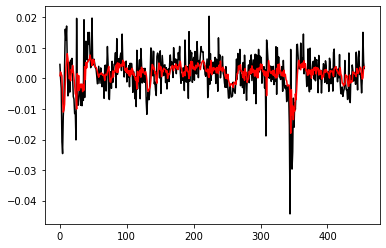

In [79]:
# plot predictions
plt.plot(indpro_oos, color='black')
plt.plot(svr_pred, color='red')
plt.show()